## Анализ и подготовка плана действий по удержанию клиентов с использованием  машинного обучения

# Цель проекта:
**Разработка стратегии взаимодействия с клиентами на основе аналитических данных**

Задачи для достижения цели:
* спрогнозировать вероятность оттока (на уровне следующего месяца) для каждого клиента;  
* сформировать типичные портреты клиентов: выделить несколько наиболее ярких групп и охарактеризовать их основные свойства;  
* проанализировать основные признаки, наиболее сильно влияющие на отток;  
* сформулировать основные выводы и разработать рекомендации по повышению качества работы с клиентами:  
    * 1) выделить целевые группы клиентов;  
    * 2) предложить меры по снижению оттока;  
    * 3) определить другие особенности взаимодействия с клиентами.  

**Описание:**

В нашем распоряжении сведения в csv-файле. Заказчик подготовил данные, которые содержат данные на месяц до оттока и факт оттока на определённый месяц. Набор данных включает следующие поля:  
* Данные клиента за предыдущий до проверки факта оттока месяц:  
    * 'gender' — пол;  
    * 'Near_Location' — проживание или работа в районе, где находится фитнес-центр;  
    * 'Partner' — сотрудник компании-партнёра клуба (сотрудничество с компаниями, чьи сотрудники могут получать скидки на абонемент — в таком случае фитнес-центр хранит информацию о работодателе клиента);  
    * 'Promo_friends' — факт первоначальной записи в рамках акции «приведи друга» (использовал промо-код от знакомого при оплате первого абонемента);
    * 'Phone' — наличие контактного телефона;  
    * 'Age' — возраст;  
    * 'Lifetime' — время с момента первого обращения в фитнес-центр (в месяцах).  
* Информация на основе журнала посещений, покупок и информация о текущем статусе абонемента клиента:  
    * 'Contract_period' — длительность текущего действующего абонемента (месяц, 6 месяцев, год);  
    * 'Month_to_end_contract' — срок до окончания текущего действующего абонемента (в месяцах);  
    * 'Group_visits' — факт посещения групповых занятий;  
    * 'Avg_class_frequency_total' — средняя частота посещений в неделю за все время с начала действия абонемента;  
    * 'Avg_class_frequency_current_month' — средняя частота посещений в неделю за предыдущий месяц;  
    * 'Avg_additional_charges_total' — суммарная выручка от других услуг фитнес-центра: кафе, спорттовары, косметический и массажный салон.  
* 'Churn' — факт оттока в текущем месяце.

## Изучение и предобработка данных из файлов

Прочитаем данные в таблицe. Предварительно изучим на корректность. Импортируем все необходимые библиотеки, создадим функции для просмотра и изучения данных.

In [1]:
# импорт библиотеки pandas
import pandas as pd
from pandas.plotting import register_matplotlib_converters
pd.set_option('mode.chained_assignment', None)
register_matplotlib_converters()
pd.options.display.max_colwidth = 100
pd.set_option('mode.chained_assignment', None)
import warnings
warnings.filterwarnings('ignore')
# импорт библиотеки seaborn
import seaborn as sns
# импорт библиотеки matplotlib
import matplotlib.pyplot as plt
# импорт библиотеки numpy
import numpy as np
# импорт библиотеки datetime
import datetime as dt
from datetime import datetime, timedelta
# импорт библиотеки scipy.stats
import scipy.stats as stats


# импорт библиотек sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
#from sklearn.linear_model import Lasso, Ridge

from sklearn.linear_model import LogisticRegression
#from sklearn.tree import DecisionTreeRegressor
#from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
#from sklearn.metrics import roc_auc_score

from scipy.cluster.hierarchy import dendrogram, linkage 


from sklearn.cluster import KMeans
import itertools



In [2]:
# создадим фукцию для вывода общей инфрмации по таблице целиком
def tab_info(df_x, name):
# получение первых строк таблицы df
    print('Первые строки таблицы', name)
    try:
        display(df_x.head(10))
    except:
        display(df_x.head(2))
# получение случайных строк таблицы df
    print('Cлучайные строки таблицы', name)
    try:
        display(df_x.sample(10))
    except:
        display(df_x.sample(2))
# получение последних строк таблицы df
    print('Последние строки таблицы', name)
    try:
        display(df_x.tail(10))
    except:
        display(df_x.tail(2))
# получение cводной информации по параметрам данных
    print('Сводная информация по параметрам данных', name)
    display(df_x.describe().round(2))
# подсчет количества отсутствующих значений
    print('Количество отсутствующих значений', name)
    display(df_x.isna().sum())
# подсчет доли отсутствующих значений с округлением
    print('Доли отсутствующих значений с округлением', name)
    display(round(df_x.isna().sum() * 100 / len(df_x), 2))
# подсчет количества задублированных записей
    print('Задублированных записей', name)
    display(df_x.duplicated().sum())    
# получение общей информации о данных в таблице
    print('Общая информация о данных в таблице', name)
    display(df_x.info())

In [3]:
# создадим фукцию для вывода инфрмации по столбцу таблицы для числовых данных (должно быть не менее 10 строк)
def col_info_num(df_x, name):
# выведем тип данных столбца
    print('Тип данных', name)
    display(df_x[name].dtypes)
# анализ столбца методом подсчета уникальных значений и количества их упоминаний
    print('Уникальные значения и количество их упоминаний в столбце', name)
    display(df_x[name].value_counts())
# посмотрим максимальные значения
    print('Максимальные значения столбца', name)
    display(df_x.nlargest(10, name))
# получение случайных 10 строк
    print('Cлучайные 10 строк')
    display(df_x.sample(10))   
# посмотрим минимальные значения
    print('Минимальные значения столбца', name)
    display(df_x.nsmallest(10, name))
# проверим столбец на отрицательные значения    
    print('Отрицательные значения столбца', name)
    display(df_x.loc[df_x.loc[:,name] < 0][name].count())
# подсчет отсутствующих значений
    print('Отсутствующие значения', name)
    display(df_x[name].isna().sum())
# подсчет доли отсутствующих значений с округлением
    print('Доли отсутствующих значений с округлением', name)
    display(round(df_x[name].isna().sum() * 100 / len(df_x[name]), 2))
# получение cводной информации по параметрам данных
    print('Сводная информация по параметрам данных', name)
    display(round(df_x[name].describe(), 2))
# построим график распределения данных
    print('График распределения данных', name)
    plt.boxplot(x=df_x[name]);

In [4]:
# создадим фукцию для вывода инфрмации по столбцу таблицы для не числовых данных (должно быть не менее 10 строк)
def col_info_not_num(df_x, name):
# выведем тип данных столбца
    print('Тип данных', name)
    display(df_x[name].dtypes)
# анализ столбца методом подсчета уникальных значений и количества их упоминаний
    print('Уникальные значения и количество их упоминаний в столбце', name)
    display(df_x[name].value_counts())
# получение случайных 10 строк
    print('Cлучайные 10 строк')
    display(df_x.sample(10))
# подсчет отсутствующих значений
    print('Отсутствующие значения', name)
    display(df_x[name].isna().sum())
# подсчет доли отсутствующих значений с округлением
    print('Доли отсутствующих значений с округлением', name)
    display(round(df_x[name].isna().sum() * 100 / len(df_x[name]), 2))

In [5]:
# чтение файлов с данными и сохранение в df
df = pd.read_csv('/datasets/gym_churn.csv') 

In [6]:
# вывод общей инфрмации по таблице целиком
tab_info(df, 'gym_churn')

Первые строки таблицы gym_churn


,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
0,1,1,1,1,0,6,1,29,14.227470,5.0,3,0.020398,0.000000,0
1,0,1,0,0,1,12,1,31,113.202938,12.0,7,1.922936,1.910244,0
2,0,1,1,0,1,1,0,28,129.448479,1.0,2,1.859098,1.736502,0
3,0,1,1,1,1,12,1,33,62.669863,12.0,2,3.205633,3.357215,0
4,1,1,1,1,1,1,0,26,198.362265,1.0,3,1.113884,1.120078,0
5,1,1,0,0,1,1,1,34,450.743960,1.0,3,2.623477,2.637007,0
6,1,1,1,1,0,6,1,32,94.266389,6.0,2,1.138941,1.277242,0
7,0,1,0,0,1,1,0,30,217.786641,1.0,0,1.213502,1.049387,1
8,1,1,1,1,1,1,1,23,45.409909,1.0,1,1.106239,1.059333,0
9,0,1,0,0,1,1,0,31,65.310836,1.0,11,1.810852,1.951368,0


Cлучайные строки таблицы gym_churn


,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
989,0,1,1,0,1,6,1,29,13.295275,6.0,3,1.216385,1.178248,0
1307,1,1,1,1,1,6,0,33,148.472639,6.0,3,3.648101,3.603093,0
2219,1,1,0,0,0,6,1,24,160.516203,6.0,1,2.872276,2.998211,0
1028,0,0,0,0,1,1,0,25,30.712653,1.0,1,1.840854,0.806634,1
3560,0,1,0,0,1,12,1,29,363.861394,12.0,5,3.363988,3.525827,0
3463,0,1,0,0,1,1,0,33,14.852519,1.0,3,0.055140,0.000000,1
1945,0,1,1,0,1,1,0,26,24.081862,1.0,0,2.330230,1.440560,1
1232,0,1,0,0,1,1,1,26,188.060194,1.0,2,1.100923,0.789772,1
1499,0,1,1,0,0,6,1,29,116.966521,6.0,9,4.096405,4.079059,0
58,1,1,1,1,1,6,0,28,115.774878,6.0,2,0.633592,0.755100,0


Последние строки таблицы gym_churn


,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
3990,1,0,1,0,1,12,0,33,31.771147,8.0,10,1.831577,1.924509,0
3991,1,0,1,0,1,6,0,33,69.301270,6.0,1,1.367289,1.435721,0
3992,0,1,1,1,1,12,0,31,223.102448,8.0,4,3.855916,3.797062,0
3993,0,1,1,0,1,1,0,33,231.778628,1.0,3,1.418791,1.450442,0
3994,1,1,0,0,1,1,0,26,31.066721,1.0,1,1.157451,0.269597,1
3995,1,1,1,0,1,12,0,33,2.406023,12.0,8,2.284497,2.349070,0
3996,0,1,0,0,1,1,1,29,68.883764,1.0,1,1.277168,0.292859,1
3997,1,1,1,1,1,12,0,28,78.250542,11.0,2,2.786146,2.831439,0
3998,0,1,1,1,1,6,0,32,61.912657,5.0,3,1.630108,1.596237,0
3999,1,0,1,0,0,12,1,30,178.861814,12.0,1,1.101832,1.035270,0


Сводная информация по параметрам данных gym_churn


,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
count,4000.00,4000.00,4000.00,4000.00,4000.0,4000.00,4000.00,4000.00,4000.00,4000.00,4000.00,4000.00,4000.00,4000.00
mean,0.51,0.85,0.49,0.31,0.9,4.68,0.41,29.18,146.94,4.32,3.72,1.88,1.77,0.27
std,0.50,0.36,0.50,0.46,0.3,4.55,0.49,3.26,96.36,4.19,3.75,0.97,1.05,0.44
min,0.00,0.00,0.00,0.00,0.0,1.00,0.00,18.00,0.15,1.00,0.00,0.00,0.00,0.00
25%,0.00,1.00,0.00,0.00,1.0,1.00,0.00,27.00,68.87,1.00,1.00,1.18,0.96,0.00
50%,1.00,1.00,0.00,0.00,1.0,1.00,0.00,29.00,136.22,1.00,3.00,1.83,1.72,0.00
75%,1.00,1.00,1.00,1.00,1.0,6.00,1.00,31.00,210.95,6.00,5.00,2.54,2.51,1.00
max,1.00,1.00,1.00,1.00,1.0,12.00,1.00,41.00,552.59,12.00,31.00,6.02,6.15,1.00


Количество отсутствующих значений gym_churn


gender                               0
Near_Location                        0
Partner                              0
Promo_friends                        0
Phone                                0
Contract_period                      0
Group_visits                         0
Age                                  0
Avg_additional_charges_total         0
Month_to_end_contract                0
Lifetime                             0
Avg_class_frequency_total            0
Avg_class_frequency_current_month    0
Churn                                0
dtype: int64

Доли отсутствующих значений с округлением gym_churn


gender                               0.0
Near_Location                        0.0
Partner                              0.0
Promo_friends                        0.0
Phone                                0.0
Contract_period                      0.0
Group_visits                         0.0
Age                                  0.0
Avg_additional_charges_total         0.0
Month_to_end_contract                0.0
Lifetime                             0.0
Avg_class_frequency_total            0.0
Avg_class_frequency_current_month    0.0
Churn                                0.0
dtype: float64

Задублированных записей gym_churn


0

Общая информация о данных в таблице gym_churn
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 14 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   gender                             4000 non-null   int64  
 1   Near_Location                      4000 non-null   int64  
 2   Partner                            4000 non-null   int64  
 3   Promo_friends                      4000 non-null   int64  
 4   Phone                              4000 non-null   int64  
 5   Contract_period                    4000 non-null   int64  
 6   Group_visits                       4000 non-null   int64  
 7   Age                                4000 non-null   int64  
 8   Avg_additional_charges_total       4000 non-null   float64
 9   Month_to_end_contract              4000 non-null   float64
 10  Lifetime                           4000 non-null   int64  
 11  Avg_class_

None

Итак, в таблице 14 столбцов и 4000 строк. Названия столбцов составлены с использованием заглавной буквы, приведем названия к нижнему регистру. Тип данных в столбцах — int64(10), float64(4). Пропусков нет ни в одной строке, полностью задублированных записей тоже нет. Все данные в таблице - числовые.

In [7]:
# приведем названия столбцов к хорошему стилю
df.columns = df.columns.str.lower()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 14 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   gender                             4000 non-null   int64  
 1   near_location                      4000 non-null   int64  
 2   partner                            4000 non-null   int64  
 3   promo_friends                      4000 non-null   int64  
 4   phone                              4000 non-null   int64  
 5   contract_period                    4000 non-null   int64  
 6   group_visits                       4000 non-null   int64  
 7   age                                4000 non-null   int64  
 8   avg_additional_charges_total       4000 non-null   float64
 9   month_to_end_contract              4000 non-null   float64
 10  lifetime                           4000 non-null   int64  
 11  avg_class_frequency_total          4000 non-null   float

Рассмотрим каждый столбец в отдельности.

### 'gender' — пол

Тип данных gender


dtype('int64')

Уникальные значения и количество их упоминаний в столбце gender


1    2041
0    1959
Name: gender, dtype: int64

Максимальные значения столбца gender


,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month,churn
0,1,1,1,1,0,6,1,29,14.227470,5.0,3,0.020398,0.000000,0
4,1,1,1,1,1,1,0,26,198.362265,1.0,3,1.113884,1.120078,0
5,1,1,0,0,1,1,1,34,450.743960,1.0,3,2.623477,2.637007,0
6,1,1,1,1,0,6,1,32,94.266389,6.0,2,1.138941,1.277242,0
8,1,1,1,1,1,1,1,23,45.409909,1.0,1,1.106239,1.059333,0
11,1,1,1,0,1,1,0,27,266.783824,1.0,2,2.348535,1.584316,1
13,1,1,0,0,1,1,1,27,152.748668,1.0,1,0.000000,0.000000,1
19,1,1,1,1,1,12,1,29,73.917546,11.0,14,1.141327,1.158455,0
20,1,1,0,0,1,6,1,29,338.596859,6.0,1,3.563599,3.479553,0
22,1,1,0,0,1,12,1,29,100.158130,12.0,1,3.899715,3.709855,0


Cлучайные 10 строк


,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month,churn
164,0,1,1,1,1,6,0,34,75.046235,5.0,5,1.432464,1.510779,0
2696,1,1,0,1,1,12,1,31,261.618269,12.0,10,0.598709,0.629289,0
277,0,1,1,1,1,12,1,35,302.878535,9.0,4,4.661961,4.733059,0
2963,0,1,0,0,1,1,1,31,82.599966,1.0,3,1.229400,1.096888,0
2832,1,1,0,0,0,1,0,26,115.487561,1.0,0,0.915357,0.000000,1
114,0,1,1,1,1,12,1,32,258.648383,12.0,2,0.927543,0.928326,0
2583,0,1,1,0,1,1,1,33,204.667802,1.0,1,0.387635,0.477012,0
1598,1,1,1,0,1,12,1,25,39.770287,9.0,12,2.789625,2.845273,0
3977,1,1,0,0,1,1,0,29,93.817092,1.0,0,0.444837,0.000000,1
1084,0,1,1,1,0,12,0,23,198.505331,10.0,8,0.627617,0.612831,0


Минимальные значения столбца gender


,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month,churn
1,0,1,0,0,1,12,1,31,113.202938,12.0,7,1.922936,1.910244,0
2,0,1,1,0,1,1,0,28,129.448479,1.0,2,1.859098,1.736502,0
3,0,1,1,1,1,12,1,33,62.669863,12.0,2,3.205633,3.357215,0
7,0,1,0,0,1,1,0,30,217.786641,1.0,0,1.213502,1.049387,1
9,0,1,0,0,1,1,0,31,65.310836,1.0,11,1.810852,1.951368,0
10,0,1,0,0,0,6,1,32,229.708945,6.0,3,1.641180,1.367714,0
12,0,1,1,1,1,1,1,33,148.418053,1.0,4,3.368606,3.391853,0
14,0,1,0,0,1,6,0,35,209.888133,3.0,8,1.978084,2.117349,0
15,0,1,1,1,1,12,0,29,101.372604,10.0,4,2.850402,2.836455,0
16,0,1,1,1,1,1,1,31,11.975295,1.0,0,3.342261,3.206223,0


Отрицательные значения столбца gender


0

Отсутствующие значения gender


0

Доли отсутствующих значений с округлением gender


0.0

Сводная информация по параметрам данных gender


count    4000.00
mean        0.51
std         0.50
min         0.00
25%         0.00
50%         1.00
75%         1.00
max         1.00
Name: gender, dtype: float64

График распределения данных gender


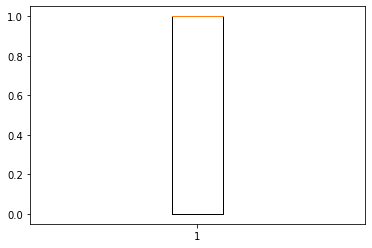

In [8]:
# вывод инфрмации по столбцу таблицы
col_info_num(df, 'gender')

---

**Выводы:**

* Тип данных: int64 соответствует смыслу, хоть и подразумевает категориальные данные, здесь заказчик не указал какой пол подразумевает 0 и 1. Пол 1 немного больше в данных. На анализе и выводах это не должно сказаться.
* Артефакты: не обнаружено
* Пропуски: нет
* Стиль значений: в хорошем стиле

### 'near_location' — проживание или работа в районе, где находится фитнес-центр

Тип данных near_location


dtype('int64')

Уникальные значения и количество их упоминаний в столбце near_location


1    3381
0     619
Name: near_location, dtype: int64

Максимальные значения столбца near_location


,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month,churn
0,1,1,1,1,0,6,1,29,14.227470,5.0,3,0.020398,0.000000,0
1,0,1,0,0,1,12,1,31,113.202938,12.0,7,1.922936,1.910244,0
2,0,1,1,0,1,1,0,28,129.448479,1.0,2,1.859098,1.736502,0
3,0,1,1,1,1,12,1,33,62.669863,12.0,2,3.205633,3.357215,0
4,1,1,1,1,1,1,0,26,198.362265,1.0,3,1.113884,1.120078,0
5,1,1,0,0,1,1,1,34,450.743960,1.0,3,2.623477,2.637007,0
6,1,1,1,1,0,6,1,32,94.266389,6.0,2,1.138941,1.277242,0
7,0,1,0,0,1,1,0,30,217.786641,1.0,0,1.213502,1.049387,1
8,1,1,1,1,1,1,1,23,45.409909,1.0,1,1.106239,1.059333,0
9,0,1,0,0,1,1,0,31,65.310836,1.0,11,1.810852,1.951368,0


Cлучайные 10 строк


,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month,churn
722,0,1,0,0,1,12,1,24,241.291955,12.0,2,2.051571,1.920687,0
846,0,0,0,0,1,1,0,30,155.025211,1.0,3,1.032163,0.943424,0
3493,1,1,1,1,1,1,0,22,21.790643,1.0,1,2.263115,1.845582,1
3468,1,1,0,0,1,1,0,26,132.661905,1.0,1,2.583829,1.879056,1
3450,1,0,0,0,1,12,0,30,101.752247,12.0,10,3.601065,3.646987,0
1304,0,1,1,0,1,6,0,25,117.342293,6.0,3,1.840695,1.827383,0
55,0,1,1,1,0,1,0,30,194.669178,1.0,4,1.893015,1.900943,0
1825,1,1,1,1,1,1,0,24,375.755291,1.0,2,0.219775,0.459291,0
902,0,0,0,0,1,1,0,31,71.479108,1.0,4,4.698029,4.482545,0
1439,0,1,1,0,1,1,0,30,214.659029,1.0,3,2.093652,2.097295,0


Минимальные значения столбца near_location


,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month,churn
21,0,0,0,0,1,1,0,30,153.198594,1.0,3,0.636382,0.000000,1
25,0,0,0,0,1,1,0,29,57.730007,1.0,0,1.491187,1.246807,1
51,1,0,1,0,1,1,0,29,373.066503,1.0,0,1.685823,1.661742,0
75,1,0,0,0,1,1,0,30,8.398417,1.0,2,1.851313,1.363330,1
76,1,0,0,0,1,1,1,30,249.513088,1.0,2,0.875440,1.002299,0
79,0,0,0,0,1,1,0,25,277.713652,1.0,12,3.411635,3.341780,0
89,1,0,1,0,1,1,0,27,22.331679,1.0,5,0.474777,0.502559,0
91,1,0,0,0,0,1,0,28,168.777586,1.0,6,2.191898,2.142851,0
105,1,0,0,0,1,1,1,23,181.459716,1.0,1,1.928169,1.531734,1
108,0,0,0,0,1,1,1,30,167.044500,1.0,7,2.344395,2.493626,0


Отрицательные значения столбца near_location


0

Отсутствующие значения near_location


0

Доли отсутствующих значений с округлением near_location


0.0

Сводная информация по параметрам данных near_location


count    4000.00
mean        0.85
std         0.36
min         0.00
25%         1.00
50%         1.00
75%         1.00
max         1.00
Name: near_location, dtype: float64

График распределения данных near_location


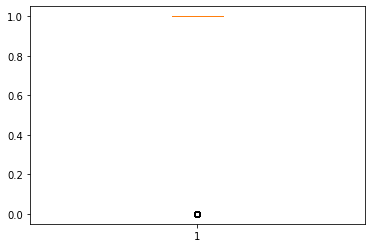

In [9]:
# вывод инфрмации по столбцу таблицы
col_info_num(df, 'near_location')

---

**Выводы:**

* Тип данных: int64 соответствует смыслу, хоть и подразумевает категориальные данные, здесь заказчик не указал что подразумевает 0 и 1. near_location 1 намного больше в данных, скорее всего это означает, что проживание или работа в одном районе с фитнес-центром. На анализе и выводах это не должно сказаться.
* Артефакты: не обнаружено
* Пропуски: нет
* Стиль значений: в хорошем стиле

### 'partner' — сотрудник компании-партнёра клуба

(сотрудничество с компаниями, чьи сотрудники могут получать скидки на абонемент — в таком случае фитнес-центр хранит информацию о работодателе клиента)

Тип данных partner


dtype('int64')

Уникальные значения и количество их упоминаний в столбце partner


0    2053
1    1947
Name: partner, dtype: int64

Максимальные значения столбца partner


,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month,churn
0,1,1,1,1,0,6,1,29,14.227470,5.0,3,0.020398,0.000000,0
2,0,1,1,0,1,1,0,28,129.448479,1.0,2,1.859098,1.736502,0
3,0,1,1,1,1,12,1,33,62.669863,12.0,2,3.205633,3.357215,0
4,1,1,1,1,1,1,0,26,198.362265,1.0,3,1.113884,1.120078,0
6,1,1,1,1,0,6,1,32,94.266389,6.0,2,1.138941,1.277242,0
8,1,1,1,1,1,1,1,23,45.409909,1.0,1,1.106239,1.059333,0
11,1,1,1,0,1,1,0,27,266.783824,1.0,2,2.348535,1.584316,1
12,0,1,1,1,1,1,1,33,148.418053,1.0,4,3.368606,3.391853,0
15,0,1,1,1,1,12,0,29,101.372604,10.0,4,2.850402,2.836455,0
16,0,1,1,1,1,1,1,31,11.975295,1.0,0,3.342261,3.206223,0


Cлучайные 10 строк


,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month,churn
1111,0,1,1,1,1,6,0,24,65.202380,4.0,2,0.853426,0.602995,1
779,1,1,1,1,1,1,1,29,99.184272,1.0,4,3.713576,3.742706,0
3228,0,1,1,0,1,1,1,26,24.392447,1.0,1,1.399085,0.854328,1
380,1,1,1,1,0,1,1,34,185.147633,1.0,4,2.337586,2.379837,0
1381,1,1,0,0,1,1,0,22,15.785805,1.0,1,1.935779,2.334859,1
2766,1,0,0,0,1,6,1,31,142.382578,6.0,11,2.455802,2.457739,0
693,1,0,1,0,1,12,0,26,147.446650,4.0,4,2.724391,2.624799,0
925,1,1,0,1,1,1,1,31,101.323360,1.0,10,3.206092,3.192700,0
1982,0,0,1,0,1,1,0,21,61.503330,1.0,1,0.696585,0.000000,1
2558,1,1,0,0,1,12,1,25,48.155282,10.0,0,1.689700,1.645644,0


Минимальные значения столбца partner


,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month,churn
1,0,1,0,0,1,12,1,31,113.202938,12.0,7,1.922936,1.910244,0
5,1,1,0,0,1,1,1,34,450.743960,1.0,3,2.623477,2.637007,0
7,0,1,0,0,1,1,0,30,217.786641,1.0,0,1.213502,1.049387,1
9,0,1,0,0,1,1,0,31,65.310836,1.0,11,1.810852,1.951368,0
10,0,1,0,0,0,6,1,32,229.708945,6.0,3,1.641180,1.367714,0
13,1,1,0,0,1,1,1,27,152.748668,1.0,1,0.000000,0.000000,1
14,0,1,0,0,1,6,0,35,209.888133,3.0,8,1.978084,2.117349,0
17,0,1,0,1,1,6,1,29,92.787414,5.0,1,0.664482,0.609945,0
18,0,1,0,0,1,1,1,30,97.804315,1.0,8,1.507076,1.578738,0
20,1,1,0,0,1,6,1,29,338.596859,6.0,1,3.563599,3.479553,0


Отрицательные значения столбца partner


0

Отсутствующие значения partner


0

Доли отсутствующих значений с округлением partner


0.0

Сводная информация по параметрам данных partner


count    4000.00
mean        0.49
std         0.50
min         0.00
25%         0.00
50%         0.00
75%         1.00
max         1.00
Name: partner, dtype: float64

График распределения данных partner


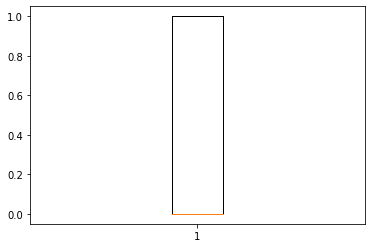

In [10]:
# вывод инфрмации по столбцу таблицы
col_info_num(df, 'partner')

---

**Выводы:**

* Тип данных: int64 соответствует смыслу, хоть и подразумевает категориальные данные, здесь заказчик не указал что подразумевает 0 и 1. partner 0 немного больше в данных, скорее всего это означает, что данный клиент не является сотудником компании-партнера. На анализе и выводах это не должно сказаться.
* Артефакты: не обнаружено
* Пропуски: нет
* Стиль значений: в хорошем стиле

### 'promo_friends' — факт первоначальной записи в рамках акции «приведи друга»

(использовал промо-код от знакомого при оплате первого абонемента);

Тип данных promo_friends


dtype('int64')

Уникальные значения и количество их упоминаний в столбце promo_friends


0    2766
1    1234
Name: promo_friends, dtype: int64

Максимальные значения столбца promo_friends


,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month,churn
0,1,1,1,1,0,6,1,29,14.227470,5.0,3,0.020398,0.000000,0
3,0,1,1,1,1,12,1,33,62.669863,12.0,2,3.205633,3.357215,0
4,1,1,1,1,1,1,0,26,198.362265,1.0,3,1.113884,1.120078,0
6,1,1,1,1,0,6,1,32,94.266389,6.0,2,1.138941,1.277242,0
8,1,1,1,1,1,1,1,23,45.409909,1.0,1,1.106239,1.059333,0
12,0,1,1,1,1,1,1,33,148.418053,1.0,4,3.368606,3.391853,0
15,0,1,1,1,1,12,0,29,101.372604,10.0,4,2.850402,2.836455,0
16,0,1,1,1,1,1,1,31,11.975295,1.0,0,3.342261,3.206223,0
17,0,1,0,1,1,6,1,29,92.787414,5.0,1,0.664482,0.609945,0
19,1,1,1,1,1,12,1,29,73.917546,11.0,14,1.141327,1.158455,0


Cлучайные 10 строк


,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month,churn
725,1,0,0,0,1,1,0,27,70.446821,1.0,0,0.235155,0.000000,1
3350,0,1,1,0,1,6,0,28,137.743800,6.0,2,1.240471,1.383924,0
321,1,1,0,0,0,1,0,27,56.178614,1.0,0,1.982850,1.338571,1
39,1,1,0,1,0,6,1,35,233.239548,6.0,0,1.270752,1.206591,0
1413,0,1,1,1,1,1,0,23,154.152359,1.0,0,1.094044,0.000000,1
2983,1,1,0,0,1,1,0,29,75.538085,1.0,0,1.700321,1.283061,1
2344,1,1,1,1,1,12,0,30,221.216191,12.0,9,0.000000,0.046870,0
257,1,1,0,0,1,1,1,32,28.944546,1.0,2,2.846286,2.780504,0
355,0,1,1,1,1,1,1,30,83.809056,1.0,9,0.000000,0.000000,0
135,1,0,0,0,1,1,0,33,262.717473,1.0,9,3.463364,3.597863,0


Минимальные значения столбца promo_friends


,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month,churn
1,0,1,0,0,1,12,1,31,113.202938,12.0,7,1.922936,1.910244,0
2,0,1,1,0,1,1,0,28,129.448479,1.0,2,1.859098,1.736502,0
5,1,1,0,0,1,1,1,34,450.743960,1.0,3,2.623477,2.637007,0
7,0,1,0,0,1,1,0,30,217.786641,1.0,0,1.213502,1.049387,1
9,0,1,0,0,1,1,0,31,65.310836,1.0,11,1.810852,1.951368,0
10,0,1,0,0,0,6,1,32,229.708945,6.0,3,1.641180,1.367714,0
11,1,1,1,0,1,1,0,27,266.783824,1.0,2,2.348535,1.584316,1
13,1,1,0,0,1,1,1,27,152.748668,1.0,1,0.000000,0.000000,1
14,0,1,0,0,1,6,0,35,209.888133,3.0,8,1.978084,2.117349,0
18,0,1,0,0,1,1,1,30,97.804315,1.0,8,1.507076,1.578738,0


Отрицательные значения столбца promo_friends


0

Отсутствующие значения promo_friends


0

Доли отсутствующих значений с округлением promo_friends


0.0

Сводная информация по параметрам данных promo_friends


count    4000.00
mean        0.31
std         0.46
min         0.00
25%         0.00
50%         0.00
75%         1.00
max         1.00
Name: promo_friends, dtype: float64

График распределения данных promo_friends


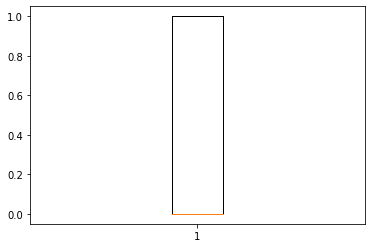

In [11]:
# вывод инфрмации по столбцу таблицы
col_info_num(df, 'promo_friends')

---

**Выводы:**

* Тип данных: int64 соответствует смыслу, хоть и подразумевает категориальные данные, здесь заказчик не указал что подразумевает 0 и 1. promo_friends 0 намного больше в данных, скорее всего это означает, что данный клиент не использовал промо-код. На анализе и выводах это не должно сказаться.
* Артефакты: не обнаружено
* Пропуски: нет
* Стиль значений: в хорошем стиле

### 'phone' — наличие контактного телефона

Тип данных phone


dtype('int64')

Уникальные значения и количество их упоминаний в столбце phone


1    3614
0     386
Name: phone, dtype: int64

Максимальные значения столбца phone


,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month,churn
1,0,1,0,0,1,12,1,31,113.202938,12.0,7,1.922936,1.910244,0
2,0,1,1,0,1,1,0,28,129.448479,1.0,2,1.859098,1.736502,0
3,0,1,1,1,1,12,1,33,62.669863,12.0,2,3.205633,3.357215,0
4,1,1,1,1,1,1,0,26,198.362265,1.0,3,1.113884,1.120078,0
5,1,1,0,0,1,1,1,34,450.743960,1.0,3,2.623477,2.637007,0
7,0,1,0,0,1,1,0,30,217.786641,1.0,0,1.213502,1.049387,1
8,1,1,1,1,1,1,1,23,45.409909,1.0,1,1.106239,1.059333,0
9,0,1,0,0,1,1,0,31,65.310836,1.0,11,1.810852,1.951368,0
11,1,1,1,0,1,1,0,27,266.783824,1.0,2,2.348535,1.584316,1
12,0,1,1,1,1,1,1,33,148.418053,1.0,4,3.368606,3.391853,0


Cлучайные 10 строк


,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month,churn
1282,1,1,0,0,0,1,0,21,184.965683,1.0,2,1.540802,0.860052,1
1479,1,0,0,0,0,1,0,25,78.707246,1.0,0,1.125181,1.096580,1
249,0,1,0,0,1,1,0,32,166.004116,1.0,7,3.723612,3.694482,0
1102,0,0,1,1,1,1,0,32,124.096758,1.0,1,2.868706,2.992209,0
1458,1,1,0,0,0,1,0,25,76.190616,1.0,2,1.940429,1.196067,1
978,1,1,1,0,1,1,0,32,180.763590,1.0,1,1.611664,1.763303,0
2667,1,1,0,0,1,12,0,34,249.732456,12.0,2,1.532257,1.650610,0
1923,1,1,0,0,1,1,0,34,41.011694,1.0,7,0.705544,0.608227,0
1114,0,1,1,0,1,12,1,33,200.071542,12.0,4,3.379991,3.398492,0
1925,0,1,0,0,1,6,0,35,72.623348,6.0,1,0.964873,0.958706,0


Минимальные значения столбца phone


,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month,churn
0,1,1,1,1,0,6,1,29,14.227470,5.0,3,0.020398,0.000000,0
6,1,1,1,1,0,6,1,32,94.266389,6.0,2,1.138941,1.277242,0
10,0,1,0,0,0,6,1,32,229.708945,6.0,3,1.641180,1.367714,0
24,0,1,0,1,0,6,0,27,179.555457,6.0,6,3.393161,3.282515,0
36,0,1,0,0,0,1,0,34,65.742743,1.0,1,1.069989,1.051995,0
39,1,1,0,1,0,6,1,35,233.239548,6.0,0,1.270752,1.206591,0
41,0,1,1,1,0,1,0,25,161.607349,1.0,1,0.878950,0.009244,1
43,0,1,1,1,0,1,1,30,261.713188,1.0,4,3.863329,3.808262,0
55,0,1,1,1,0,1,0,30,194.669178,1.0,4,1.893015,1.900943,0
62,0,1,1,1,0,6,0,34,72.641112,6.0,2,0.000000,0.000000,0


Отрицательные значения столбца phone


0

Отсутствующие значения phone


0

Доли отсутствующих значений с округлением phone


0.0

Сводная информация по параметрам данных phone


count    4000.0
mean        0.9
std         0.3
min         0.0
25%         1.0
50%         1.0
75%         1.0
max         1.0
Name: phone, dtype: float64

График распределения данных phone


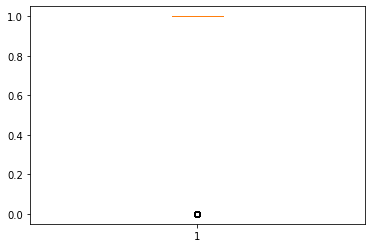

In [12]:
# вывод инфрмации по столбцу таблицы
col_info_num(df, 'phone')

---

**Выводы:**

* Тип данных: int64 соответствует смыслу, хоть и подразумевает категориальные данные, здесь заказчик не указал что подразумевает 0 и 1. phone 1 намного больше в данных, скорее всего это означает, что данный клиент указал свой телефон. На анализе и выводах это не должно сказаться.
* Артефакты: не обнаружено
* Пропуски: нет
* Стиль значений: в хорошем стиле

### 'age' — возраст

Тип данных age


dtype('int64')

Уникальные значения и количество их упоминаний в столбце age


29    468
30    457
28    447
31    434
27    378
32    364
26    300
33    253
25    231
34    174
24    148
35     98
23     82
36     48
22     33
37     29
21     24
20     14
38     10
39      3
18      2
19      2
41      1
Name: age, dtype: int64

Максимальные значения столбца age


,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month,churn
3240,0,1,0,0,1,1,1,41,310.463578,1.0,1,0.324260,0.420895,0
1305,1,1,0,1,1,6,0,39,345.430298,6.0,5,4.675341,4.700164,0
2553,1,0,1,0,1,6,0,39,113.547254,6.0,7,3.685728,3.886263,0
3944,1,1,0,0,1,6,1,39,140.829270,6.0,9,1.995093,1.946726,0
798,0,1,1,0,1,12,1,38,76.994722,12.0,13,0.479678,0.341593,0
1243,0,1,0,0,1,1,0,38,53.540153,1.0,5,2.821721,2.786275,0
1959,0,1,0,0,1,6,0,38,221.172794,6.0,4,2.637362,2.643271,0
1989,0,1,0,0,0,1,0,38,89.755916,1.0,1,2.229832,1.653470,1
2068,1,1,0,0,1,1,0,38,248.948508,1.0,7,2.680702,2.538791,0
2373,1,1,1,1,1,12,0,38,242.585245,12.0,4,2.288493,2.415398,0


Cлучайные 10 строк


,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month,churn
3876,0,1,0,0,1,1,1,27,142.842080,1.0,0,2.056122,1.478568,1
635,1,1,0,0,1,1,0,24,56.521769,1.0,0,2.666857,2.287135,1
3928,0,1,1,1,1,6,1,30,50.874507,6.0,10,1.693018,1.712572,0
2230,0,1,1,1,1,12,1,29,260.507459,12.0,2,2.348167,2.323455,0
3571,1,1,1,0,0,12,1,35,174.654400,11.0,3,3.471504,3.456041,0
2492,0,1,0,0,1,1,0,27,20.950113,1.0,2,0.523117,0.616272,0
3791,1,1,1,1,1,1,1,34,71.542798,1.0,2,4.248851,4.364278,0
436,1,1,0,0,1,6,0,28,0.434087,6.0,3,1.981469,2.124236,0
2565,0,1,1,1,1,6,0,35,196.440361,6.0,3,0.624704,0.649683,0
559,1,1,0,0,1,1,0,33,143.290410,1.0,4,2.003939,1.812209,0


Минимальные значения столбца age


,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month,churn
1973,0,1,0,0,1,1,0,18,71.404089,1.0,0,2.255383,1.109729,1
2126,0,0,1,0,1,1,0,18,28.734693,1.0,2,0.723203,0.000000,1
376,0,1,0,0,1,1,1,19,162.873354,1.0,0,0.827058,0.240369,1
2617,1,1,0,0,1,1,1,19,248.687182,1.0,0,0.998505,0.836992,0
785,1,0,0,0,1,1,0,20,117.765922,1.0,2,0.897463,0.012794,1
1013,1,1,1,1,1,12,1,20,100.198007,5.0,5,2.213092,2.345301,0
2191,1,1,0,0,1,1,1,20,155.597506,1.0,0,2.150481,1.864235,1
2314,0,1,0,0,1,1,0,20,58.360607,1.0,1,2.098280,2.355221,1
2354,1,0,0,0,1,1,0,20,304.535649,1.0,1,2.484111,2.573159,0
2719,0,0,0,0,1,1,1,20,131.978970,1.0,1,0.169254,0.024341,1


Отрицательные значения столбца age


0

Отсутствующие значения age


0

Доли отсутствующих значений с округлением age


0.0

Сводная информация по параметрам данных age


count    4000.00
mean       29.18
std         3.26
min        18.00
25%        27.00
50%        29.00
75%        31.00
max        41.00
Name: age, dtype: float64

График распределения данных age


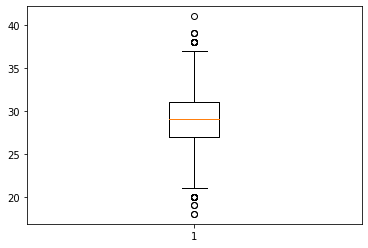

In [13]:
# вывод инфрмации по столбцу таблицы
col_info_num(df, 'age')

---

**Выводы:**

* Тип данных: int64 соответствует смыслу.
* Артефакты: не обнаружено. Средний возраст 29 лет, на графике видно нормальное распределение
* Пропуски: нет
* Стиль значений: в хорошем стиле

### 'lifetime' — время с момента первого обращения в фитнес-центр (в месяцах)

Тип данных lifetime


dtype('int64')

Уникальные значения и количество их упоминаний в столбце lifetime


1     843
2     610
3     490
0     487
4     383
5     273
6     220
7     167
8     111
9     100
10     76
12     53
11     48
13     28
15     24
14     24
16     15
17     11
19      7
18      7
20      7
21      5
26      2
24      2
22      2
23      2
27      1
29      1
31      1
Name: lifetime, dtype: int64

Максимальные значения столбца lifetime


,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month,churn
897,1,1,0,0,1,12,0,31,116.054082,10.0,31,2.378748,2.307312,0
2873,1,1,0,0,1,1,0,29,183.715050,1.0,29,1.750208,1.608273,0
1810,0,1,1,0,1,12,1,29,193.176830,7.0,27,0.000000,0.000000,0
915,1,1,1,1,0,12,1,30,256.685355,11.0,26,1.202611,1.384090,0
2355,0,1,0,0,1,1,0,30,40.559417,1.0,26,1.663034,1.750301,0
648,0,1,0,1,1,1,1,26,160.655676,1.0,24,1.659919,1.695997,0
3491,0,0,0,0,1,6,0,27,137.370917,6.0,24,0.918920,1.093414,0
1056,1,1,1,0,1,1,1,28,272.153780,1.0,23,3.020039,3.029276,0
3768,0,1,0,0,1,12,1,35,178.797307,9.0,23,2.524003,2.525501,0
730,0,1,1,0,0,1,0,29,5.283815,1.0,22,3.480428,3.534252,0


Cлучайные 10 строк


,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month,churn
1953,0,1,1,1,1,12,0,31,259.260308,11.0,1,0.849582,0.876414,0
2171,0,1,0,0,1,1,1,28,203.710379,1.0,0,1.476274,1.483000,1
3621,1,0,0,0,1,12,0,28,351.633792,12.0,3,2.176554,2.179913,0
761,0,1,0,0,1,1,1,27,472.318897,1.0,5,3.547490,3.755130,0
3602,0,1,1,1,1,1,1,35,144.909739,1.0,11,4.091156,4.146970,0
2296,0,1,0,0,1,1,1,29,98.341502,1.0,1,2.851058,2.843733,0
2662,1,1,0,1,1,6,1,29,3.375953,6.0,1,0.000000,0.000000,0
124,1,0,1,0,1,1,1,28,162.554565,1.0,1,1.110288,1.174486,0
597,1,0,1,0,0,1,0,31,99.650032,1.0,4,2.422482,2.255136,0
3631,0,1,0,0,1,1,1,31,145.167792,1.0,5,1.795299,1.698245,0


Минимальные значения столбца lifetime


,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month,churn
7,0,1,0,0,1,1,0,30,217.786641,1.0,0,1.213502,1.049387,1
16,0,1,1,1,1,1,1,31,11.975295,1.0,0,3.342261,3.206223,0
25,0,0,0,0,1,1,0,29,57.730007,1.0,0,1.491187,1.246807,1
39,1,1,0,1,0,6,1,35,233.239548,6.0,0,1.270752,1.206591,0
46,1,1,0,0,1,1,0,26,54.184236,1.0,0,0.854079,0.000000,1
51,1,0,1,0,1,1,0,29,373.066503,1.0,0,1.685823,1.661742,0
57,0,1,0,0,1,6,1,27,236.915828,6.0,0,0.996493,0.000000,1
70,1,1,1,0,0,1,0,27,228.071951,1.0,0,1.719377,1.340514,1
71,0,1,1,1,1,12,0,26,174.978054,11.0,0,1.061644,1.027229,0
72,1,1,1,1,1,6,0,29,134.564112,5.0,0,1.725835,0.894815,1


Отрицательные значения столбца lifetime


0

Отсутствующие значения lifetime


0

Доли отсутствующих значений с округлением lifetime


0.0

Сводная информация по параметрам данных lifetime


count    4000.00
mean        3.72
std         3.75
min         0.00
25%         1.00
50%         3.00
75%         5.00
max        31.00
Name: lifetime, dtype: float64

График распределения данных lifetime


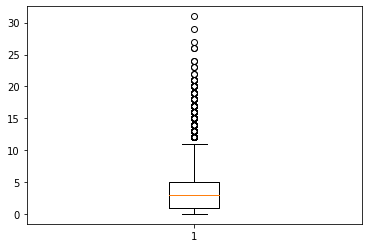

In [14]:
# вывод инфрмации по столбцу таблицы
col_info_num(df, 'lifetime')

---

**Выводы:**

* Тип данных: int64 соответствует смыслу.
* Артефакты: в данных есть 0, скорее всего это клиенты текущего месяца, самый популярный lifetime - 1 месяц, среднее значение 3,72. 
* Пропуски: нет
* Стиль значений: в хорошем стиле

### 'contract_period' — длительность текущего действующего абонемента (месяц, 6 месяцев, год)

Тип данных contract_period


dtype('int64')

Уникальные значения и количество их упоминаний в столбце contract_period


1     2207
12     960
6      833
Name: contract_period, dtype: int64

Максимальные значения столбца contract_period


,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month,churn
1,0,1,0,0,1,12,1,31,113.202938,12.0,7,1.922936,1.910244,0
3,0,1,1,1,1,12,1,33,62.669863,12.0,2,3.205633,3.357215,0
15,0,1,1,1,1,12,0,29,101.372604,10.0,4,2.850402,2.836455,0
19,1,1,1,1,1,12,1,29,73.917546,11.0,14,1.141327,1.158455,0
22,1,1,0,0,1,12,1,29,100.158130,12.0,1,3.899715,3.709855,0
31,0,1,0,0,1,12,1,32,87.856139,12.0,1,0.000000,0.000000,0
32,0,1,0,0,1,12,0,32,131.114586,12.0,3,2.374935,2.265089,0
33,0,1,1,1,1,12,0,29,208.980751,12.0,12,3.083503,3.137979,0
35,0,1,0,0,1,12,1,33,188.590863,12.0,11,0.561138,0.565911,0
38,1,1,1,1,1,12,1,25,179.038840,12.0,12,1.794939,1.716778,0


Cлучайные 10 строк


,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month,churn
3379,1,1,1,1,1,1,0,27,43.835414,1.0,3,0.000000,0.000000,1
2195,1,1,0,0,1,1,1,34,302.717320,1.0,5,0.810037,0.762467,0
1906,0,0,1,0,1,1,0,25,113.056915,1.0,2,0.273748,0.000000,1
2123,0,1,1,0,1,1,1,28,47.454051,1.0,2,0.752629,0.660481,1
2034,0,1,0,0,1,6,1,22,153.164836,6.0,3,2.066584,2.116715,0
1045,1,1,0,0,1,6,0,26,396.070447,6.0,1,2.326107,2.385412,0
3983,1,1,0,1,1,1,1,31,44.685951,1.0,1,0.000000,0.000000,0
3355,0,1,0,0,1,12,0,37,133.450411,12.0,3,2.130940,2.010455,0
611,1,1,0,0,1,1,0,29,90.752133,1.0,7,2.705633,2.605287,0
1036,0,0,1,0,1,1,0,32,63.672700,1.0,8,1.575633,1.616485,0


Минимальные значения столбца contract_period


,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month,churn
2,0,1,1,0,1,1,0,28,129.448479,1.0,2,1.859098,1.736502,0
4,1,1,1,1,1,1,0,26,198.362265,1.0,3,1.113884,1.120078,0
5,1,1,0,0,1,1,1,34,450.743960,1.0,3,2.623477,2.637007,0
7,0,1,0,0,1,1,0,30,217.786641,1.0,0,1.213502,1.049387,1
8,1,1,1,1,1,1,1,23,45.409909,1.0,1,1.106239,1.059333,0
9,0,1,0,0,1,1,0,31,65.310836,1.0,11,1.810852,1.951368,0
11,1,1,1,0,1,1,0,27,266.783824,1.0,2,2.348535,1.584316,1
12,0,1,1,1,1,1,1,33,148.418053,1.0,4,3.368606,3.391853,0
13,1,1,0,0,1,1,1,27,152.748668,1.0,1,0.000000,0.000000,1
16,0,1,1,1,1,1,1,31,11.975295,1.0,0,3.342261,3.206223,0


Отрицательные значения столбца contract_period


0

Отсутствующие значения contract_period


0

Доли отсутствующих значений с округлением contract_period


0.0

Сводная информация по параметрам данных contract_period


count    4000.00
mean        4.68
std         4.55
min         1.00
25%         1.00
50%         1.00
75%         6.00
max        12.00
Name: contract_period, dtype: float64

График распределения данных contract_period


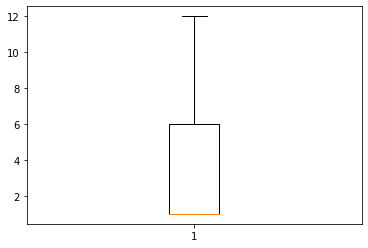

In [15]:
# вывод инфрмации по столбцу таблицы
col_info_num(df, 'contract_period')

---

**Выводы:**

* Тип данных: int64 соответствует смыслу.
* Артефакты: не обнаружено. 
* Пропуски: нет
* Стиль значений: в хорошем стиле.

Из 3 абонементов самый востребованный - 1 месяц.

### 'month_to_end_contract' — срок до окончания текущего действующего абонемента (в месяцах)

Тип данных month_to_end_contract


dtype('float64')

Уникальные значения и количество их упоминаний в столбце month_to_end_contract


1.0     2207
6.0      645
12.0     524
11.0     181
5.0      130
10.0      82
9.0       73
4.0       58
8.0       38
7.0       25
3.0       23
2.0       14
Name: month_to_end_contract, dtype: int64

Максимальные значения столбца month_to_end_contract


,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month,churn
1,0,1,0,0,1,12,1,31,113.202938,12.0,7,1.922936,1.910244,0
3,0,1,1,1,1,12,1,33,62.669863,12.0,2,3.205633,3.357215,0
22,1,1,0,0,1,12,1,29,100.158130,12.0,1,3.899715,3.709855,0
31,0,1,0,0,1,12,1,32,87.856139,12.0,1,0.000000,0.000000,0
32,0,1,0,0,1,12,0,32,131.114586,12.0,3,2.374935,2.265089,0
33,0,1,1,1,1,12,0,29,208.980751,12.0,12,3.083503,3.137979,0
35,0,1,0,0,1,12,1,33,188.590863,12.0,11,0.561138,0.565911,0
38,1,1,1,1,1,12,1,25,179.038840,12.0,12,1.794939,1.716778,0
40,0,1,1,1,1,12,0,33,5.135184,12.0,5,2.945238,3.008918,0
42,0,1,0,0,1,12,0,36,108.909443,12.0,1,2.046310,2.079704,0


Cлучайные 10 строк


,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month,churn
499,1,1,0,0,1,6,0,27,50.024629,6.0,2,2.826340,2.932442,0
2328,1,1,0,0,1,12,1,31,132.858508,12.0,3,0.608938,0.621908,0
2135,1,0,0,0,1,1,0,28,165.688580,1.0,3,2.166936,1.648868,1
2341,1,0,1,0,1,1,1,33,8.428701,1.0,4,0.408581,0.271664,0
3530,1,1,0,0,1,1,1,29,273.395960,1.0,12,1.492660,1.522410,0
208,1,1,0,0,1,1,0,23,131.111571,1.0,0,1.692632,2.279115,1
3033,0,1,1,1,1,1,1,24,56.041705,1.0,3,1.768832,1.728905,0
270,0,1,1,1,0,1,0,31,4.791324,1.0,3,1.219283,1.073094,0
1375,1,0,1,0,1,6,1,31,95.827554,6.0,2,3.050218,3.003937,0
752,1,0,1,0,1,6,1,27,18.274197,6.0,3,0.416663,0.238952,0


Минимальные значения столбца month_to_end_contract


,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month,churn
2,0,1,1,0,1,1,0,28,129.448479,1.0,2,1.859098,1.736502,0
4,1,1,1,1,1,1,0,26,198.362265,1.0,3,1.113884,1.120078,0
5,1,1,0,0,1,1,1,34,450.743960,1.0,3,2.623477,2.637007,0
7,0,1,0,0,1,1,0,30,217.786641,1.0,0,1.213502,1.049387,1
8,1,1,1,1,1,1,1,23,45.409909,1.0,1,1.106239,1.059333,0
9,0,1,0,0,1,1,0,31,65.310836,1.0,11,1.810852,1.951368,0
11,1,1,1,0,1,1,0,27,266.783824,1.0,2,2.348535,1.584316,1
12,0,1,1,1,1,1,1,33,148.418053,1.0,4,3.368606,3.391853,0
13,1,1,0,0,1,1,1,27,152.748668,1.0,1,0.000000,0.000000,1
16,0,1,1,1,1,1,1,31,11.975295,1.0,0,3.342261,3.206223,0


Отрицательные значения столбца month_to_end_contract


0

Отсутствующие значения month_to_end_contract


0

Доли отсутствующих значений с округлением month_to_end_contract


0.0

Сводная информация по параметрам данных month_to_end_contract


count    4000.00
mean        4.32
std         4.19
min         1.00
25%         1.00
50%         1.00
75%         6.00
max        12.00
Name: month_to_end_contract, dtype: float64

График распределения данных month_to_end_contract


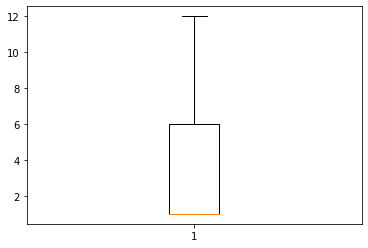

In [16]:
# вывод инфрмации по столбцу таблицы
col_info_num(df, 'month_to_end_contract')

---

**Выводы:**

* Тип данных: float64 не совсем соответствует смыслу, лучше int64, так как все значения - целочисленные
* Артефакты: не обнаружено. 
* Пропуски: нет
* Стиль значений: в хорошем стиле.

In [17]:
#преобразум в int проверим результат
df['month_to_end_contract'] = df['month_to_end_contract'].astype(int)
df['month_to_end_contract'].dtypes

dtype('int64')

### 'group_visits' — факт посещения групповых занятий

Тип данных group_visits


dtype('int64')

Уникальные значения и количество их упоминаний в столбце group_visits


0    2351
1    1649
Name: group_visits, dtype: int64

Максимальные значения столбца group_visits


,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month,churn
0,1,1,1,1,0,6,1,29,14.227470,5,3,0.020398,0.000000,0
1,0,1,0,0,1,12,1,31,113.202938,12,7,1.922936,1.910244,0
3,0,1,1,1,1,12,1,33,62.669863,12,2,3.205633,3.357215,0
5,1,1,0,0,1,1,1,34,450.743960,1,3,2.623477,2.637007,0
6,1,1,1,1,0,6,1,32,94.266389,6,2,1.138941,1.277242,0
8,1,1,1,1,1,1,1,23,45.409909,1,1,1.106239,1.059333,0
10,0,1,0,0,0,6,1,32,229.708945,6,3,1.641180,1.367714,0
12,0,1,1,1,1,1,1,33,148.418053,1,4,3.368606,3.391853,0
13,1,1,0,0,1,1,1,27,152.748668,1,1,0.000000,0.000000,1
16,0,1,1,1,1,1,1,31,11.975295,1,0,3.342261,3.206223,0


Cлучайные 10 строк


,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month,churn
3863,1,1,1,0,0,1,1,27,157.123921,1,16,1.340594,1.099389,0
3458,0,0,0,0,1,12,0,28,252.160476,12,5,1.956313,2.119239,0
3933,1,1,0,0,1,6,1,28,49.939369,6,5,1.410446,1.302023,0
2325,1,1,1,1,0,6,1,28,93.195415,6,1,1.367693,0.110712,1
3683,0,1,1,1,1,1,0,25,112.669017,1,9,1.269198,1.367309,0
118,1,0,0,0,1,1,0,32,301.624707,1,3,1.208336,0.696494,1
1566,0,0,1,0,1,1,0,33,163.361799,1,1,0.992756,0.148651,1
2783,0,1,1,0,1,6,0,34,204.585210,5,2,1.805096,1.848815,0
3078,0,1,0,0,1,1,1,28,22.166232,1,1,2.808649,2.858603,0
763,1,1,1,0,1,6,0,30,79.494545,2,3,2.981531,3.035320,0


Минимальные значения столбца group_visits


,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month,churn
2,0,1,1,0,1,1,0,28,129.448479,1,2,1.859098,1.736502,0
4,1,1,1,1,1,1,0,26,198.362265,1,3,1.113884,1.120078,0
7,0,1,0,0,1,1,0,30,217.786641,1,0,1.213502,1.049387,1
9,0,1,0,0,1,1,0,31,65.310836,1,11,1.810852,1.951368,0
11,1,1,1,0,1,1,0,27,266.783824,1,2,2.348535,1.584316,1
14,0,1,0,0,1,6,0,35,209.888133,3,8,1.978084,2.117349,0
15,0,1,1,1,1,12,0,29,101.372604,10,4,2.850402,2.836455,0
21,0,0,0,0,1,1,0,30,153.198594,1,3,0.636382,0.000000,1
24,0,1,0,1,0,6,0,27,179.555457,6,6,3.393161,3.282515,0
25,0,0,0,0,1,1,0,29,57.730007,1,0,1.491187,1.246807,1


Отрицательные значения столбца group_visits


0

Отсутствующие значения group_visits


0

Доли отсутствующих значений с округлением group_visits


0.0

Сводная информация по параметрам данных group_visits


count    4000.00
mean        0.41
std         0.49
min         0.00
25%         0.00
50%         0.00
75%         1.00
max         1.00
Name: group_visits, dtype: float64

График распределения данных group_visits


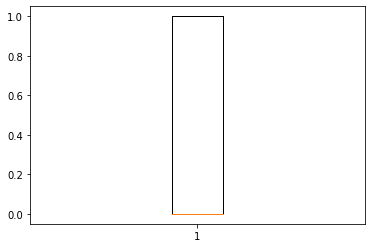

In [18]:
# вывод инфрмации по столбцу таблицы
col_info_num(df, 'group_visits')

---

**Выводы:**

* Тип данных: int64 соответствует смыслу, хоть и подразумевает категориальные данные, здесь заказчик не указал что подразумевает 0 и 1. group_visits 0 больше в данных, скорее всего это означает, что данный клиент не посещал группых занятий. На анализе и выводах это не должно сказаться.
* Артефакты: не обнаружено
* Пропуски: нет
* Стиль значений: в хорошем стиле

### 'avg_class_frequency_total' — средняя частота посещений в неделю за все время с начала действия абонемента

Тип данных avg_class_frequency_total


dtype('float64')

Уникальные значения и количество их упоминаний в столбце avg_class_frequency_total


0.000000    88
0.827058     1
2.770845     1
1.472779     1
3.735185     1
            ..
2.602823     1
1.295159     1
1.138963     1
2.262743     1
0.992312     1
Name: avg_class_frequency_total, Length: 3913, dtype: int64

Максимальные значения столбца avg_class_frequency_total


,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month,churn
2178,0,1,1,1,1,6,1,29,113.628580,6,2,6.023668,6.146783,0
2248,0,1,0,0,1,6,0,33,374.407447,4,5,5.421898,5.458295,0
110,0,1,0,0,1,12,1,27,234.769930,11,4,5.410054,5.368415,0
1309,1,1,1,1,1,1,0,35,305.178334,1,1,5.141852,4.962540,0
3628,1,1,1,1,1,12,1,33,42.635201,12,2,5.079242,4.976680,0
1807,1,1,1,1,1,1,1,30,71.772789,1,10,4.953290,4.909602,0
3765,1,1,0,0,1,6,1,28,156.907842,5,2,4.844771,4.925905,0
2095,0,1,0,0,0,12,1,35,131.796279,8,11,4.793780,4.729706,0
2274,0,1,1,1,1,6,1,26,203.549333,6,6,4.777897,4.714158,0
1320,1,1,0,1,1,1,0,33,12.056007,1,6,4.699018,4.786793,0


Cлучайные 10 строк


,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month,churn
3426,0,1,1,0,1,12,1,27,78.071855,12,1,1.565410,0.559215,1
745,1,1,1,0,1,6,0,27,72.221025,6,7,0.378365,0.283937,0
1168,0,0,0,0,1,1,0,26,115.359883,1,1,2.819232,2.376044,1
839,0,1,1,1,1,12,0,32,137.847147,11,3,2.234328,2.176056,0
2085,1,1,1,0,1,12,0,27,236.632339,12,0,2.965682,2.971532,0
879,1,1,0,0,1,1,0,26,132.305823,1,0,0.744655,0.366327,1
83,1,1,0,0,1,1,0,23,27.725167,1,1,1.740580,1.135342,1
3180,0,1,1,0,1,6,0,31,246.423372,6,3,2.124553,2.096608,0
3091,0,0,0,0,1,1,0,24,51.252090,1,2,1.496060,0.711247,1
3240,0,1,0,0,1,1,1,41,310.463578,1,1,0.324260,0.420895,0


Минимальные значения столбца avg_class_frequency_total


,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month,churn
13,1,1,0,0,1,1,1,27,152.748668,1,1,0.0,0.000000,1
31,0,1,0,0,1,12,1,32,87.856139,12,1,0.0,0.000000,0
59,1,1,1,1,1,1,0,34,166.862754,1,10,0.0,0.000000,0
62,0,1,1,1,0,6,0,34,72.641112,6,2,0.0,0.000000,0
128,1,0,1,0,1,6,0,29,291.731275,5,0,0.0,0.000000,1
166,0,1,0,0,1,6,0,29,143.135489,5,4,0.0,0.000000,0
224,1,1,1,0,1,1,1,34,190.750507,1,1,0.0,0.000000,0
274,0,1,1,1,1,12,1,30,131.662702,9,5,0.0,0.089707,0
355,0,1,1,1,1,1,1,30,83.809056,1,9,0.0,0.000000,0
385,1,1,0,1,1,1,0,33,209.542824,1,17,0.0,0.000000,0


Отрицательные значения столбца avg_class_frequency_total


0

Отсутствующие значения avg_class_frequency_total


0

Доли отсутствующих значений с округлением avg_class_frequency_total


0.0

Сводная информация по параметрам данных avg_class_frequency_total


count    4000.00
mean        1.88
std         0.97
min         0.00
25%         1.18
50%         1.83
75%         2.54
max         6.02
Name: avg_class_frequency_total, dtype: float64

График распределения данных avg_class_frequency_total


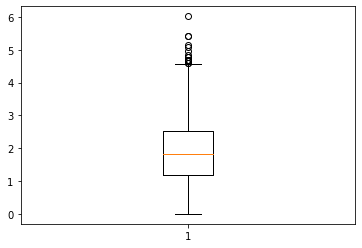

In [19]:
# вывод инфрмации по столбцу таблицы
col_info_num(df, 'avg_class_frequency_total')

---

**Выводы:**

* Тип данных: float64 соответствует смыслу.
* Артефакты: не обнаружено. 
* Пропуски: нет
* Стиль значений: в хорошем стиле.  

Среднее количество посещений в неделю за все время - 1,88, 5 клиентов посещали фитнес более 5 раз в неделю, распределение нормальное.

### 'avg_class_frequency_current_month' — средняя частота посещений в неделю за предыдущий месяц

Тип данных avg_class_frequency_current_month


dtype('float64')

Уникальные значения и количество их упоминаний в столбце avg_class_frequency_current_month


0.000000    181
0.379235      1
0.054540      1
1.877288      1
1.058906      1
           ... 
3.115417      1
3.429058      1
3.233156      1
2.564243      1
1.454710      1
Name: avg_class_frequency_current_month, Length: 3820, dtype: int64

Максимальные значения столбца avg_class_frequency_current_month


,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month,churn
2178,0,1,1,1,1,6,1,29,113.628580,6,2,6.023668,6.146783,0
2248,0,1,0,0,1,6,0,33,374.407447,4,5,5.421898,5.458295,0
110,0,1,0,0,1,12,1,27,234.769930,11,4,5.410054,5.368415,0
3101,1,0,1,0,1,6,0,29,209.805109,6,8,4.681557,5.024721,0
3628,1,1,1,1,1,12,1,33,42.635201,12,2,5.079242,4.976680,0
1309,1,1,1,1,1,1,0,35,305.178334,1,1,5.141852,4.962540,0
3765,1,1,0,0,1,6,1,28,156.907842,5,2,4.844771,4.925905,0
1807,1,1,1,1,1,1,1,30,71.772789,1,10,4.953290,4.909602,0
1320,1,1,0,1,1,1,0,33,12.056007,1,6,4.699018,4.786793,0
2992,0,1,1,1,1,1,1,27,365.027518,1,3,4.531969,4.779963,0


Cлучайные 10 строк


,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month,churn
3621,1,0,0,0,1,12,0,28,351.633792,12,3,2.176554,2.179913,0
3698,0,1,0,0,1,1,0,33,60.202737,1,1,1.559161,1.520917,0
1517,0,1,1,1,1,1,0,34,280.189493,1,2,2.793180,2.724581,1
3396,1,1,1,1,1,1,1,29,75.019423,1,6,1.645020,1.761901,0
64,0,1,1,0,1,6,0,30,95.378529,6,2,2.917374,2.968504,0
2901,0,1,0,0,0,1,1,31,29.953094,1,4,2.575846,2.568086,0
3579,1,0,0,0,1,1,0,24,109.965943,1,0,0.313905,0.000000,1
3873,0,0,0,0,1,1,0,30,102.341005,1,0,0.377650,0.000000,1
2715,0,1,0,0,1,1,1,27,117.354854,1,3,2.767132,2.895174,0
1220,1,1,1,1,1,6,1,32,67.507150,6,2,1.053588,0.935748,0


Минимальные значения столбца avg_class_frequency_current_month


,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month,churn
0,1,1,1,1,0,6,1,29,14.227470,5,3,0.020398,0.0,0
13,1,1,0,0,1,1,1,27,152.748668,1,1,0.000000,0.0,1
21,0,0,0,0,1,1,0,30,153.198594,1,3,0.636382,0.0,1
31,0,1,0,0,1,12,1,32,87.856139,12,1,0.000000,0.0,0
46,1,1,0,0,1,1,0,26,54.184236,1,0,0.854079,0.0,1
57,0,1,0,0,1,6,1,27,236.915828,6,0,0.996493,0.0,1
59,1,1,1,1,1,1,0,34,166.862754,1,10,0.000000,0.0,0
62,0,1,1,1,0,6,0,34,72.641112,6,2,0.000000,0.0,0
73,0,1,0,0,1,1,0,24,31.340569,1,1,0.465045,0.0,1
85,1,1,1,1,1,1,0,25,34.332858,1,3,0.118734,0.0,1


Отрицательные значения столбца avg_class_frequency_current_month


0

Отсутствующие значения avg_class_frequency_current_month


0

Доли отсутствующих значений с округлением avg_class_frequency_current_month


0.0

Сводная информация по параметрам данных avg_class_frequency_current_month


count    4000.00
mean        1.77
std         1.05
min         0.00
25%         0.96
50%         1.72
75%         2.51
max         6.15
Name: avg_class_frequency_current_month, dtype: float64

График распределения данных avg_class_frequency_current_month


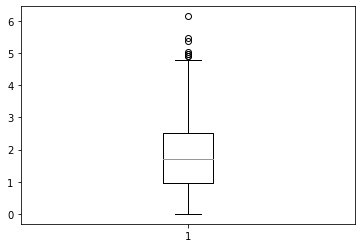

In [20]:
# вывод инфрмации по столбцу таблицы
col_info_num(df, 'avg_class_frequency_current_month')

---

**Выводы:**

* Тип данных: float64 соответствует смыслу.
* Артефакты: не обнаружено. 
* Пропуски: нет
* Стиль значений: в хорошем стиле.  

Среднее количество посещений в неделю за последний месяц - 1,77, 4 клиента посещали фитнес более 5 раз в неделю, распределение нормальное.

### 'avg_additional_charges_total' — суммарная выручка от других услуг фитнес-центра: кафе, спорттовары, косметический и массажный салон

Тип данных avg_additional_charges_total


dtype('float64')

Уникальные значения и количество их упоминаний в столбце avg_additional_charges_total


89.952762     1
174.658455    1
122.765563    1
204.444527    1
50.813166     1
             ..
272.997181    1
115.130268    1
133.525137    1
201.447650    1
218.979321    1
Name: avg_additional_charges_total, Length: 4000, dtype: int64

Максимальные значения столбца avg_additional_charges_total


,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month,churn
975,0,0,1,0,1,12,1,32,552.590740,12,1,0.887859,0.939304,0
3799,1,0,0,0,1,1,1,31,534.256182,1,2,2.325128,2.267241,0
2394,0,0,0,0,1,6,1,32,515.392606,6,4,0.000000,0.000000,0
1797,0,1,1,0,0,1,0,27,496.172222,1,6,1.630830,1.620165,0
2063,0,1,1,0,1,12,0,32,488.708175,12,2,1.073821,1.065885,0
3541,0,1,0,0,1,1,0,28,476.432655,1,4,3.207606,3.154818,0
761,0,1,0,0,1,1,1,27,472.318897,1,5,3.547490,3.755130,0
1597,0,0,0,0,1,6,0,31,471.720040,6,21,3.284087,3.294925,0
3942,0,1,0,0,1,1,0,28,468.205360,1,2,0.763912,0.660546,0
2313,0,1,0,0,1,12,1,30,466.027640,10,1,3.519716,3.548916,0


Cлучайные 10 строк


,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month,churn
1245,0,0,0,0,1,1,0,23,103.930754,1,1,1.189315,0.887563,1
1039,0,1,1,1,1,6,1,28,51.973905,6,3,3.142432,2.998336,0
2077,1,0,1,0,1,1,0,30,178.782326,1,4,2.178742,2.125643,0
2080,0,1,1,1,1,1,1,29,180.537219,1,12,1.148557,1.224606,0
3843,0,1,1,1,1,12,1,29,68.824028,12,2,1.722843,1.707953,0
909,0,1,1,0,1,6,1,36,31.551994,6,7,2.389646,2.612847,0
402,1,1,1,0,0,1,1,35,30.631645,1,3,0.966904,1.046527,0
955,0,1,1,0,1,6,1,35,225.185004,6,2,1.202485,1.164569,0
3417,0,1,1,0,1,1,1,25,128.121259,1,2,1.743256,0.141598,1
3029,0,0,1,0,1,12,0,33,193.710276,11,4,2.102714,2.137364,0


Минимальные значения столбца avg_additional_charges_total


,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month,churn
2183,1,1,1,1,1,6,1,27,0.148205,6,0,0.260201,0.000000,1
3494,0,1,0,0,1,1,1,29,0.171862,1,1,2.000838,1.831822,0
3130,1,1,0,1,1,12,0,29,0.251606,12,7,1.304149,1.226058,0
1508,0,1,0,0,1,1,0,25,0.334824,1,0,0.735515,0.000000,1
3706,1,1,1,1,1,1,0,29,0.362153,1,3,2.994457,2.810134,0
1895,1,1,0,1,1,1,1,31,0.410893,1,2,0.686252,0.556895,1
3329,1,1,0,0,1,1,0,32,0.428233,1,1,1.362647,1.353912,0
436,1,1,0,0,1,6,0,28,0.434087,6,3,1.981469,2.124236,0
754,1,1,0,0,1,1,1,33,0.510545,1,3,2.328938,2.442888,0
2600,0,1,1,0,1,6,1,29,0.556352,4,6,3.650142,3.633426,0


Отрицательные значения столбца avg_additional_charges_total


0

Отсутствующие значения avg_additional_charges_total


0

Доли отсутствующих значений с округлением avg_additional_charges_total


0.0

Сводная информация по параметрам данных avg_additional_charges_total


count    4000.00
mean      146.94
std        96.36
min         0.15
25%        68.87
50%       136.22
75%       210.95
max       552.59
Name: avg_additional_charges_total, dtype: float64

График распределения данных avg_additional_charges_total


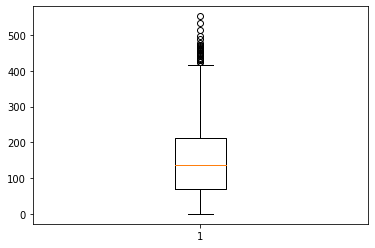

In [21]:
# вывод инфрмации по столбцу таблицы
col_info_num(df, 'avg_additional_charges_total')

---

**Выводы:**

* Тип данных: float64 соответствует смыслу.
* Артефакты: не обнаружено. 
* Пропуски: нет
* Стиль значений: в хорошем стиле.  

Здесь можно предположить что это средняя сумарная выручка клиента в месяц (avg в начале названия колонки наводит на такую мысль), но это не факт, возможно это сумма за все время пользования фитнесом (total в конце названия), оставим как есть, на анализе и выводах это не должно сказаться.

### 'churn' — факт оттока в текущем месяце

Тип данных churn


dtype('int64')

Уникальные значения и количество их упоминаний в столбце churn


0    2939
1    1061
Name: churn, dtype: int64

Максимальные значения столбца churn


,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month,churn
7,0,1,0,0,1,1,0,30,217.786641,1,0,1.213502,1.049387,1
11,1,1,1,0,1,1,0,27,266.783824,1,2,2.348535,1.584316,1
13,1,1,0,0,1,1,1,27,152.748668,1,1,0.000000,0.000000,1
21,0,0,0,0,1,1,0,30,153.198594,1,3,0.636382,0.000000,1
23,1,1,0,0,1,1,1,32,276.079882,1,1,1.420637,1.043101,1
25,0,0,0,0,1,1,0,29,57.730007,1,0,1.491187,1.246807,1
41,0,1,1,1,0,1,0,25,161.607349,1,1,0.878950,0.009244,1
46,1,1,0,0,1,1,0,26,54.184236,1,0,0.854079,0.000000,1
52,1,1,0,1,1,1,1,30,252.915683,1,1,1.491547,1.059261,1
57,0,1,0,0,1,6,1,27,236.915828,6,0,0.996493,0.000000,1


Cлучайные 10 строк


,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month,churn
3405,1,1,1,1,1,1,0,30,85.806155,1,4,3.984524,3.968041,0
78,0,1,1,0,1,6,1,30,68.786171,6,4,1.522097,1.624436,0
3700,0,1,0,0,1,1,0,30,175.880606,1,3,0.678798,0.600270,0
1800,1,1,1,0,1,1,1,35,99.655123,1,4,0.723881,0.622304,0
947,0,1,1,1,1,6,1,27,259.925536,6,4,1.443905,1.460369,0
2546,1,1,1,0,1,12,0,29,157.727843,11,16,2.026086,2.120762,0
1923,1,1,0,0,1,1,0,34,41.011694,1,7,0.705544,0.608227,0
2625,0,1,0,1,1,1,1,32,235.909933,1,19,0.764516,0.843826,0
567,1,1,0,0,1,1,0,33,160.056406,1,6,2.373122,2.323889,0
483,0,1,0,0,1,1,0,28,455.173225,1,5,2.092353,2.154556,0


Минимальные значения столбца churn


,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month,churn
0,1,1,1,1,0,6,1,29,14.227470,5,3,0.020398,0.000000,0
1,0,1,0,0,1,12,1,31,113.202938,12,7,1.922936,1.910244,0
2,0,1,1,0,1,1,0,28,129.448479,1,2,1.859098,1.736502,0
3,0,1,1,1,1,12,1,33,62.669863,12,2,3.205633,3.357215,0
4,1,1,1,1,1,1,0,26,198.362265,1,3,1.113884,1.120078,0
5,1,1,0,0,1,1,1,34,450.743960,1,3,2.623477,2.637007,0
6,1,1,1,1,0,6,1,32,94.266389,6,2,1.138941,1.277242,0
8,1,1,1,1,1,1,1,23,45.409909,1,1,1.106239,1.059333,0
9,0,1,0,0,1,1,0,31,65.310836,1,11,1.810852,1.951368,0
10,0,1,0,0,0,6,1,32,229.708945,6,3,1.641180,1.367714,0


Отрицательные значения столбца churn


0

Отсутствующие значения churn


0

Доли отсутствующих значений с округлением churn


0.0

Сводная информация по параметрам данных churn


count    4000.00
mean        0.27
std         0.44
min         0.00
25%         0.00
50%         0.00
75%         1.00
max         1.00
Name: churn, dtype: float64

График распределения данных churn


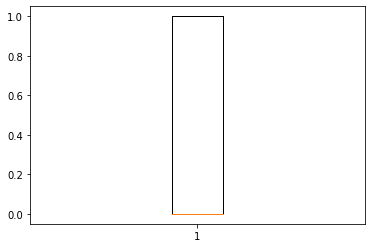

In [22]:
# вывод инфрмации по столбцу таблицы
col_info_num(df, 'churn')

---

**Выводы:**

* Тип данных: int64 соответствует смыслу, хоть и подразумевает категориальные данные, здесь заказчик не указал что подразумевает 0 и 1. churn 0 больше в данных, скорее всего это означает, что данный клиент остался в фитнесе, а 1 - факт отттока. На анализе и выводах это не должно сказаться.
* Артефакты: не обнаружено
* Пропуски: нет
* Стиль значений: в хорошем стиле

### Выводы

В целом предоставленные данные хорошего качества. Одну колонку преобразовали  в целочисленный формат, в названиях колонок оставили только строчные буквы. Категориальные данные зашифрованы в формате 0 и 1, но расшифровки их заказчиком не предоставлено (возможно так заказчик хочет оставить в тайне финальные выводы), можно предположить как их интерпретировать, на анализе и выводах это не должно сказаться. Выводы заказчик может скорректировать сам, подставив интерпретацию  0 и 1.

В таблице 14 столбцов и 4000 строк. Пропусков нет ни в одной строке, полностью задублированных записей тоже нет. Все данные в таблице - числовые.

* Данные клиента за предыдущий до проверки факта оттока месяц:  
    * 'gender' — пол  в формате 0 и 1;  
    * 'near_Location' — проживание или работа в районе, где находится фитнес-центр в формате 0 и 1;  
    * 'partner' — сотрудник компании-партнёра клуба (сотрудничество с компаниями, чьи сотрудники могут получать скидки на абонемент — в таком случае фитнес-центр хранит информацию о работодателе клиента)  в формате 0 и 1;  
    * 'promo_friends' — факт первоначальной записи в рамках акции «приведи друга» (использовал промо-код от знакомого при оплате первого абонемента)  в формате 0 и 1;
    * 'phone' — наличие контактного телефона  в формате 0 и 1;  
    * 'age' — возраст;  
    * 'lifetime' — время с момента первого обращения в фитнес-центр (в месяцах).  
* Информация на основе журнала посещений, покупок и информация о текущем статусе абонемента клиента:  
    * 'contract_period' — длительность текущего действующего абонемента (месяц, 6 месяцев, год);  
    * 'month_to_end_contract' — срок до окончания текущего действующего абонемента (в месяцах);  
    * 'group_visits' — факт посещения групповых занятий  в формате 0 и 1;  
    * 'avg_class_frequency_total' — средняя частота посещений в неделю за все время с начала действия абонемента;  
    * 'avg_class_frequency_current_month' — средняя частота посещений в неделю за предыдущий месяц;  
    * 'avg_additional_charges_total' — суммарная выручка от других услуг фитнес-центра: кафе, спорттовары, косметический и массажный салон.  
* 'churn' — факт оттока в текущем месяце  в формате 0 и 1.

In [23]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 14 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   gender                             4000 non-null   int64  
 1   near_location                      4000 non-null   int64  
 2   partner                            4000 non-null   int64  
 3   promo_friends                      4000 non-null   int64  
 4   phone                              4000 non-null   int64  
 5   contract_period                    4000 non-null   int64  
 6   group_visits                       4000 non-null   int64  
 7   age                                4000 non-null   int64  
 8   avg_additional_charges_total       4000 non-null   float64
 9   month_to_end_contract              4000 non-null   int64  
 10  lifetime                           4000 non-null   int64  
 11  avg_class_frequency_total          4000 non-null   float

---

Исходные данные сохранены в переменную df, готовы к дальнейшей обработке.

## Исследовательский анализ данных (EDA) групп кто ушёл (отток) и тех, кто остался (не попали в отток)

### Распределения бинарных  признаков 

In [24]:
# выделим в отдельные списки столбцы с категориальными и числовыми данными
cat_col = ['gender', 'near_location', 'partner', 'promo_friends', 'phone', 'group_visits']
val_col = ['contract_period', 'age', 'avg_additional_charges_total', 'month_to_end_contract', 'lifetime', 'avg_class_frequency_total', 'avg_class_frequency_current_month']

Количественное соотношение churn в gender расчет и график с накоплением


churn,0,1
gender,,
0,1440,519
1,1499,542


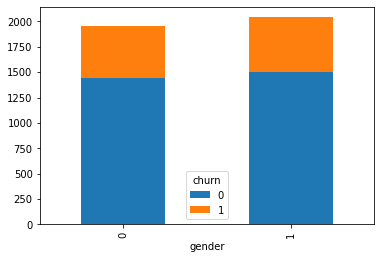

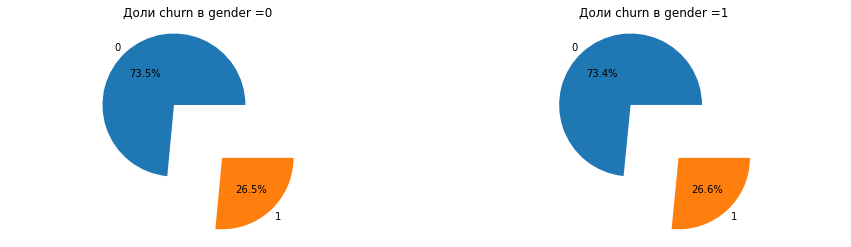

Количественное соотношение churn в near_location расчет и график с накоплением


churn,0,1
near_location,,
0,373,246
1,2566,815


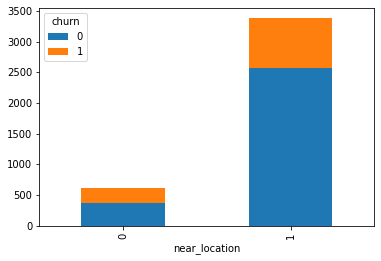

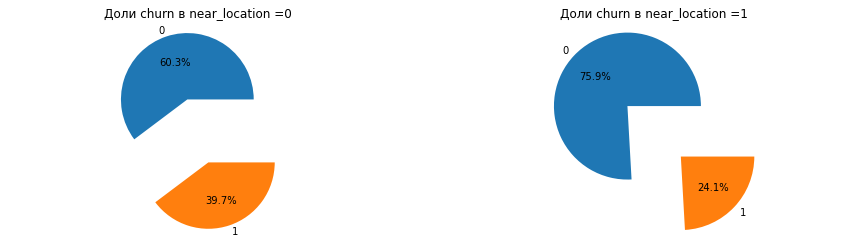

Количественное соотношение churn в partner расчет и график с накоплением


churn,0,1
partner,,
0,1369,684
1,1570,377


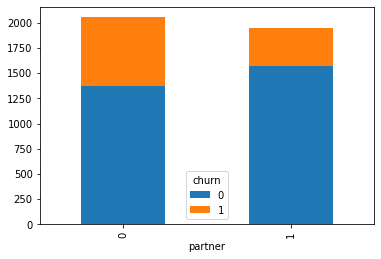

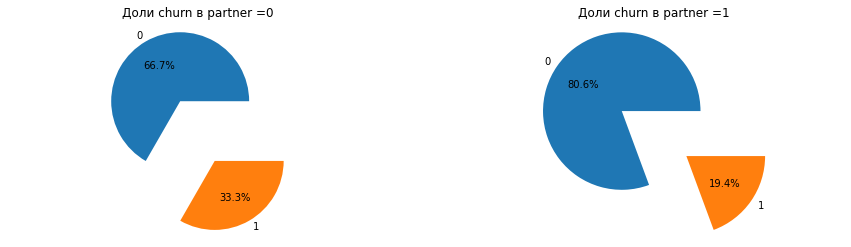

Количественное соотношение churn в promo_friends расчет и график с накоплением


churn,0,1
promo_friends,,
0,1900,866
1,1039,195


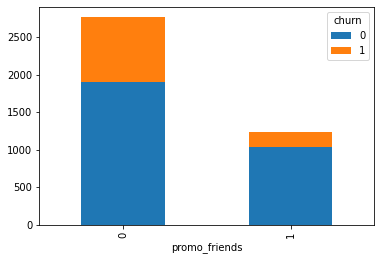

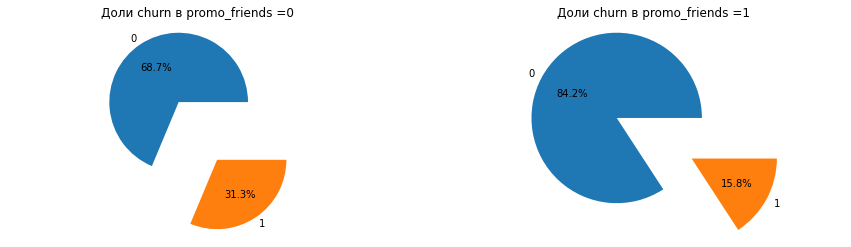

Количественное соотношение churn в phone расчет и график с накоплением


churn,0,1
phone,,
0,283,103
1,2656,958


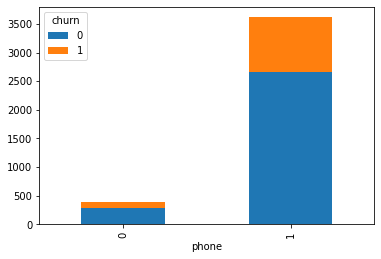

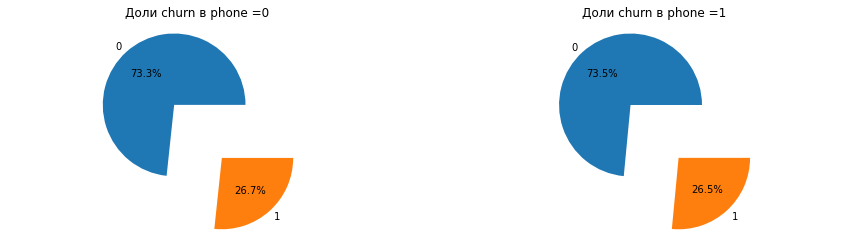

Количественное соотношение churn в group_visits расчет и график с накоплением


churn,0,1
group_visits,,
0,1575,776
1,1364,285


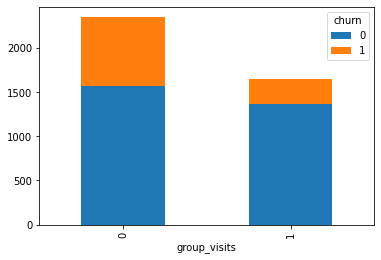

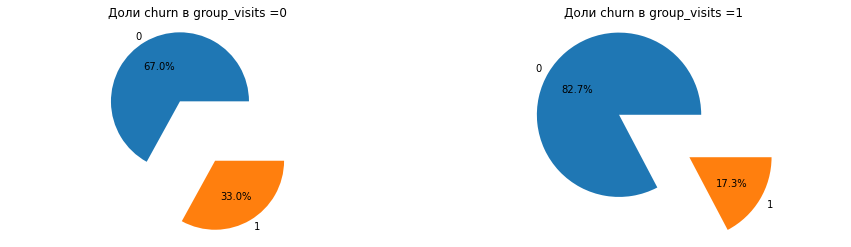

In [25]:
# # в цикле переберем все категориальные данные выраженные в 0 / 1 и рассчитаем количественное соотношение и доли в них,
# построим графики
for i in cat_col:
    df_plot_bar = df.pivot_table(index=i, columns='churn', values='age', aggfunc='count')
    print('Количественное соотношение churn в', i, 'расчет и график с накоплением')
    display(df_plot_bar)
    df_plot_bar.plot.bar(stacked=True)
    df_plot_pie = df.pivot_table(index= i, columns='churn', values='age', aggfunc='count')
    df_plot_pie = df_plot_pie.unstack(i)#.T
    df_plot_pie = df_plot_pie.reset_index()
    df_plot_pie.columns = ['churn', i, 'count']
    current_0 = df_plot_pie.loc[df_plot_pie[i] == 0]
    current_1 = df_plot_pie.loc[df_plot_pie[i] == 1]
    fig, ax = plt.subplots(1, 2, figsize=(15, 4))
    ax[0].pie(current_0['count'], current_0['churn'], current_0['churn'], autopct='%1.1f%%')
    ax[0].set_title('Доли churn в {} =0'.format(i))
    ax[0].axis("equal")
    ax[1].pie(current_1['count'], current_1['churn'], current_1['churn'], autopct='%1.1f%%')
    ax[1].set_title('Доли churn в {} =1'.format(i))
    ax[1].axis("equal");
    plt.show()

#### Выводы

----

* соотношение gender (пола) в оттоке примерно одинаково -  около 26%  
* в оттоке near_location=0 почти 40%, это гораздо больше, чем в near_location=1 (24%)  
* в оттоке partner=0 почти 33%, это гораздо больше, чем в partner=1 (19%)
* promo_friends=0 также больше promo_friends=1:  31% против 15  
* значения phone в оттоке примерно одинаково - около 25%  
* group_visits=0 дает в отток 33% против 17% в group_visits=1  

near_location, partner, promo_friends, group_visits =0 влияют на отток,  gender и phone - не вляют на отток


### Распределения непрерывных  признаков 

Распределение в  contract_period
Среднее значение в contract_period при churn=0 составляет =  5.75
Среднее значение в contract_period при churn=1 составляет =  1.73


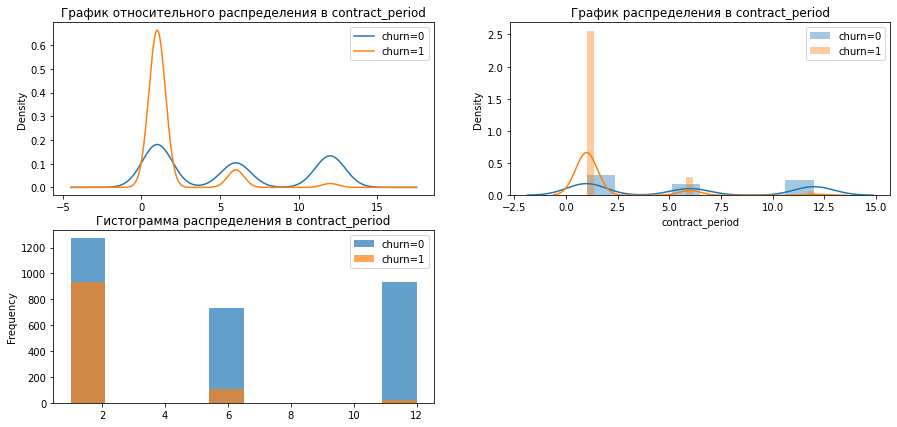

Распределение в  age
Среднее значение в age при churn=0 составляет =  29.98
Среднее значение в age при churn=1 составляет =  26.99


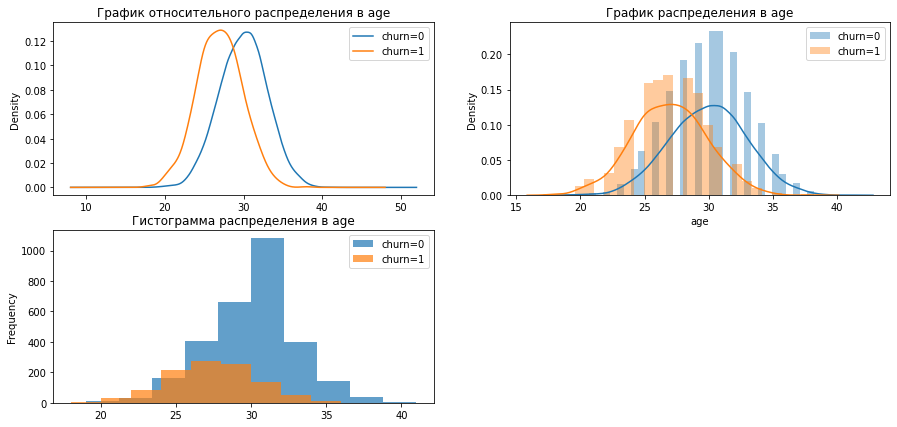

Распределение в  avg_additional_charges_total
Среднее значение в avg_additional_charges_total при churn=0 составляет =  158.45
Среднее значение в avg_additional_charges_total при churn=1 составляет =  115.08


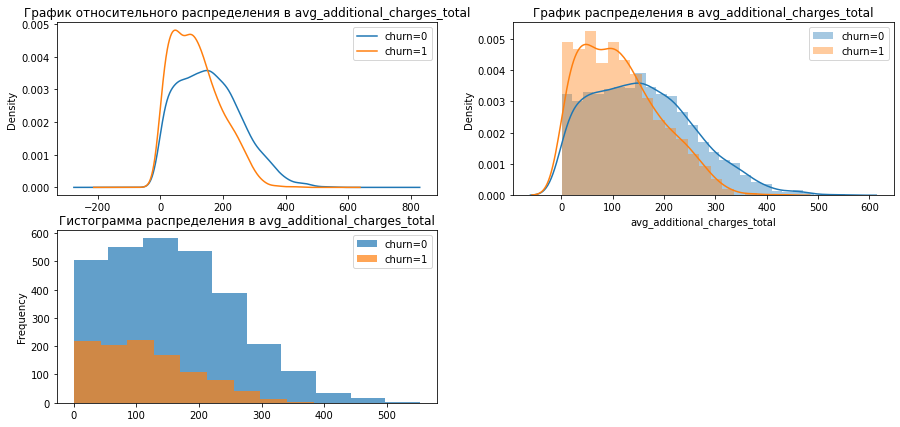

Распределение в  month_to_end_contract
Среднее значение в month_to_end_contract при churn=0 составляет =  5.28
Среднее значение в month_to_end_contract при churn=1 составляет =  1.66


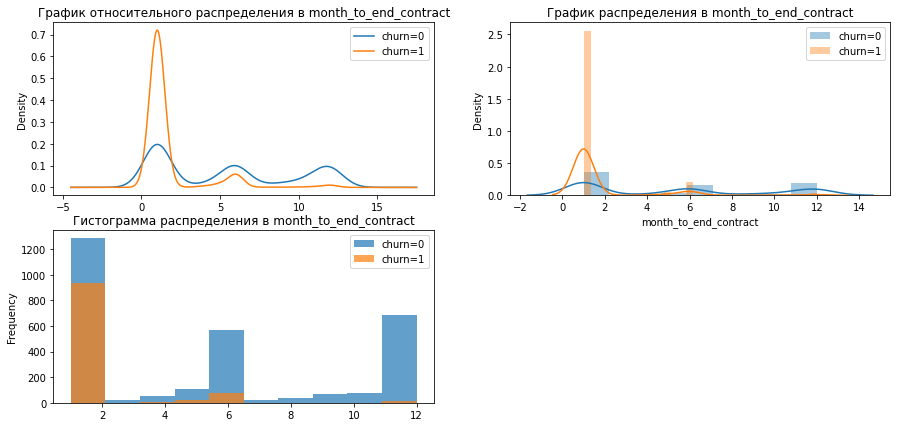

Распределение в  lifetime
Среднее значение в lifetime при churn=0 составляет =  4.71
Среднее значение в lifetime при churn=1 составляет =  0.99


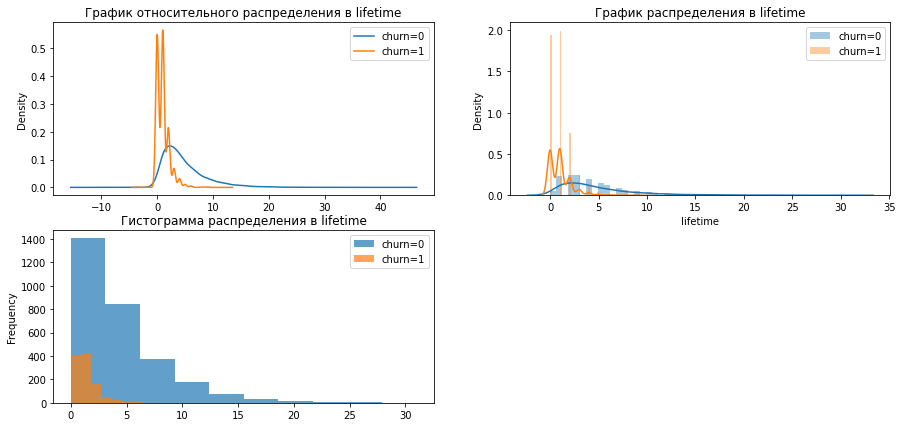

Распределение в  avg_class_frequency_total
Среднее значение в avg_class_frequency_total при churn=0 составляет =  2.02
Среднее значение в avg_class_frequency_total при churn=1 составляет =  1.47


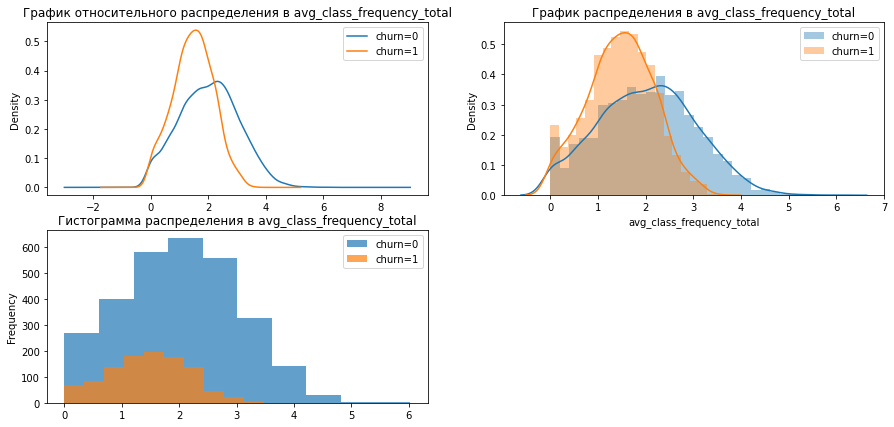

Распределение в  avg_class_frequency_current_month
Среднее значение в avg_class_frequency_current_month при churn=0 составляет =  2.03
Среднее значение в avg_class_frequency_current_month при churn=1 составляет =  1.04


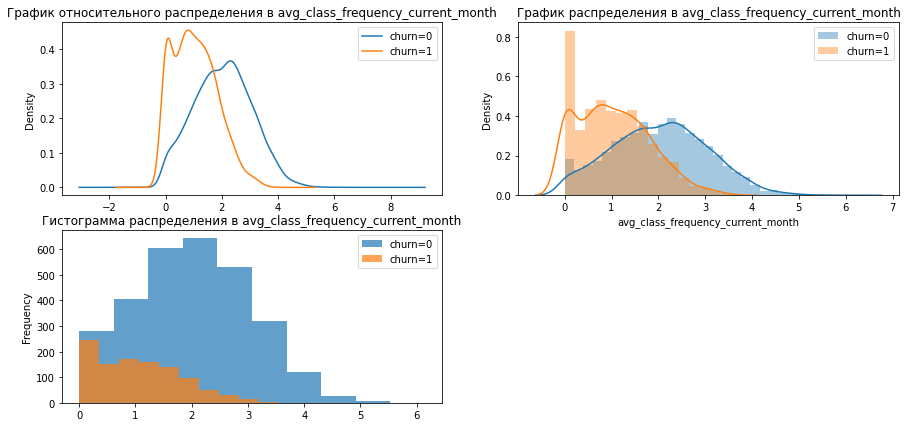

In [26]:
# в цикле переберем все числовые данные, посчитаем средние значения и построим графики
# выделим в разные переменные по факту оттока
df_0 = df.query('churn==0')
df_1 = df.query('churn==1')
for i in val_col:
    print('Распределение в ', i)
    print('Среднее значение в', i, 'при churn=0 составляет = ', round(df_0[i].mean(), 2))
    print('Среднее значение в', i, 'при churn=1 составляет = ', round(df_1[i].mean(), 2))
    fig, ax = plt.subplots(figsize=(15, 7))
    df_0[i].plot(kind='density', label='churn=0', ax = plt.subplot(2, 2, 1))
    df_1[i].plot(kind='density', label='churn=1',  ax = plt.subplot(2, 2, 1))
    plt.title('График относительного распределения в {}'. format(i))
    plt.legend()

    sns.distplot(df_0[i], label='churn=0', ax = plt.subplot(2, 2, 2))
    sns.distplot(df_1[i], label='churn=1', ax = plt.subplot(2, 2, 2))
    plt.title('График распределения в {}'. format(i))
    plt.legend()

    df_0[i].plot(kind='hist', label='churn=0', alpha=0.7, ax = plt.subplot(2, 2, 3))
    df_1[i].plot(kind='hist', label='churn=1', alpha=0.7, ax = plt.subplot(2, 2, 3))
    plt.title('Гистограмма распределения в {}'. format(i))
    plt.legend()

    plt.show();    

In [27]:
for i in enumerate(cat_col):
    print(i[0])

0
1
2
3
4
5


In [28]:
for i in enumerate(cat_col):
    print(i)

(0, 'gender')
(1, 'near_location')
(2, 'partner')
(3, 'promo_friends')
(4, 'phone')
(5, 'group_visits')


#### Выводы

----

* среднее значение contract_period при churn=1 составляет =  1.73, самое популярное время  для оттока для длительности текущего действующего абонемента - 1 месяц   
* среднее значение в age при churn=1 составляет =  26.99 - в этом возрасте отток = 1
* суммарная выручка от других услуг фитнес-центрав оттоке avg_additional_charges_total при churn=1 =  115.08
* среднее значение в month_to_end_contract при churn=1 составляет =  1.66, похоже с contract_period   
* среднее значение в lifetime при churn=1 составляет =  0.99, в оттоке не остаются на второй месяц  
* среднее значение в avg_class_frequency_total при churn=1 составляет =  1.47, средняя частота посещений "оттока" в неделю  - меньше 2х раз   
* среднее значение в avg_class_frequency_current_month при churn=1 составляет =  1.04, мало тратили в последний месяц

### Матрица корреляций 

Построим матрицу корреляция (отфильтровано по значениям корреляции churn, по уменьшению ) построим график

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month,churn
churn,0.0007,-0.1281,-0.1580,-0.1622,-0.0012,-0.3900,-0.1753,-0.4047,-0.1987,-0.3814,-0.4382,-0.2497,-0.4123,1.0000
gender,1.0000,0.0067,-0.0105,-0.0050,-0.0085,0.0005,0.0179,0.0138,-0.0093,-0.0013,0.0136,0.0146,0.0092,0.0007
phone,-0.0085,-0.0158,0.0100,0.0020,1.0000,-0.0069,-0.0101,-0.0114,0.0093,-0.0112,-0.0188,0.0083,0.0134,-0.0012
near_location,0.0067,1.0000,-0.0051,0.2110,-0.0158,0.1502,0.1547,0.0584,0.0408,0.1440,0.0709,0.0431,0.0627,-0.1281
partner,-0.0105,-0.0051,1.0000,0.4520,0.0100,0.3062,0.0227,0.0475,0.0229,0.2946,0.0612,0.0249,0.0456,-0.1580
promo_friends,-0.0050,0.2110,0.4520,1.0000,0.0020,0.2446,0.1202,0.0501,0.0369,0.2396,0.0727,0.0281,0.0538,-0.1622
group_visits,0.0179,0.1547,0.0227,0.1202,-0.0101,0.1700,1.0000,0.0809,0.0321,0.1637,0.0759,0.0567,0.0759,-0.1753
avg_additional_charges_total,-0.0093,0.0408,0.0229,0.0369,0.0093,0.1114,0.0321,0.0802,1.0000,0.1140,0.0790,0.0444,0.0796,-0.1987
avg_class_frequency_total,0.0146,0.0431,0.0249,0.0281,0.0083,0.0962,0.0567,0.1200,0.0444,0.0854,0.1123,1.0000,0.9527,-0.2497
month_to_end_contract,-0.0013,0.1440,0.2946,0.2396,-0.0112,0.9731,0.1637,0.1345,0.1140,1.0000,0.1611,0.0854,0.1476,-0.3814


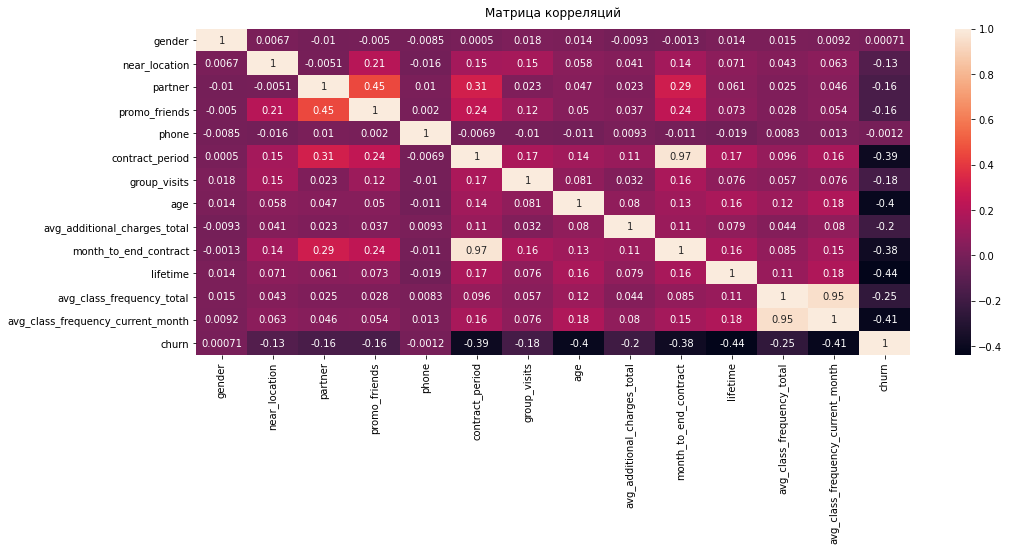

In [29]:
cm = df.corr()
plt.figure(figsize=(16, 6))
heatmap = sns.heatmap(cm, annot=True)
display(cm.sort_values(by='churn', ascending=False).style.format("{:.4f}").background_gradient(cmap='Blues'))
heatmap.set_title('Матрица корреляций', fontdict={'fontsize':12}, pad=12);

#### Выводы

Значения корреляций:  
* сильная, или тесная (при p >0,70)  
* средняя (при 0,50< p <0,69)  
* умеренная (при 0,30< p <0,49)  
* слабая (при 0,20< p <0,29)  
* очень слабая (при p <0,19)  

Все зависимости не больше умеренного уровня. И почти все обратной зависимости. Самые коррелирующие признаки:

* lifetime  
* avg_class_frequency_current_month  
* age  
* contract_period  
* month_to_end_contract  

Минимальные значения у gender и phone.


## Модель прогнозирования оттока клиентов

### Логистическая регрессией и случайный лес.

При построении матрицы корреляции на предыдущем этапе видны 2 пары признаков сильно взаимозависят друг с другом. Это:   

* contract_period и month_to_end_contract, а также  
* avg_class_frequency_total и avg_class_frequency_current_month.  

Что бы расчеты были точнее, лучше избавиться от мультиколлинеарности. Мультиколлинеарность возникает, когда есть группа линейно зависимых признаков — взаимозависимых или очень сильно скоррелированных. Поэтому оставим только 1 признак, для каждой пары сильно скоррелированных признаков, вручную удалим один:

In [30]:
# убираем один из пары коррелирующих признаков 
df.drop(['month_to_end_contract', 'avg_class_frequency_total'], axis = 1, inplace = True)
#df

Построим модель бинарной классификации клиентов, где целевой признак — факт оттока клиента в следующем месяце:

In [31]:
# разделим наши данные на признаки (матрица X) и целевую переменную (y)
X = df.drop(columns=['churn'])
y = df['churn']


In [32]:
# разделяем модель на обучающую и валидационную выборку
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [33]:
# обучим StandartScaler на обучающей выборке
scaler = StandardScaler()
scaler.fit(X_train)

# преобразуйем обучающий и валидационные наборы данных
X_train_st = scaler.transform(X_train)
X_test_st = scaler.transform(X_test)

In [34]:
# определим функцию, которая будет выводить метрики
def print_all_metrics(y_true, y_pred, y_proba, title='Метрики классификации'):
    print(title)
    print('\tAccuracy: {:.2f}'.format(accuracy_score(y_true, y_pred)))
    print('\tPrecision: {:.2f}'.format(precision_score(y_true, y_pred)))
    print('\tRecall: {:.2f}'.format(recall_score(y_true, y_pred)))


In [35]:
# зададим алгоритм для модели логистической регрессии
lr_model = LogisticRegression(random_state=0)
# обучим модель
lr_model.fit(X_train_st, y_train)
# воспользуемся уже обученной моделью, чтобы сделать прогнозы
lr_predictions = lr_model.predict(X_test_st)
lr_probabilities = lr_model.predict_proba(X_test_st)[:, 1]

# выведем все метрики
print_all_metrics(
    y_test,
    lr_predictions,
    lr_probabilities,
    title='Метрики для модели логистической регрессии:',
)


Метрики для модели логистической регрессии:
	Accuracy: 0.90
	Precision: 0.79
	Recall: 0.82


In [36]:
# зададим алгоритм для новой модели на основе алгоритма случайного леса
rf_model = RandomForestClassifier(n_estimators = 100, random_state = 0) # Ваш код здесь
# обучим модель случайного леса
rf_model.fit(X_train_st, y_train)
# воспользуемся уже обученной моделью, чтобы сделать прогнозы
rf_predictions = rf_model.predict(X_test_st)# Ваш код здесь
rf_probabilities = rf_model.predict_proba(X_test_st)[:, 1]# Ваш код здесь
# выведем все метрики
print_all_metrics(
    y_test,
    rf_predictions,
    rf_probabilities,
    title='Метрики для модели случайного леса:'
)


Метрики для модели случайного леса:
	Accuracy: 0.90
	Precision: 0.81
	Recall: 0.75


### Оценка метрик accuracy, precision и recall

Accuracy - это доля верно угаданных ответов из всех прогнозов. Чем ближе значение accuracy к 100%, тем лучше.  

Точность (precision) говорит, какая доля прогнозов относительно "1" класса верна. То есть смотрим долю правильных ответов только среди целевого класса. В бизнесе метрика precision нужна, если каждое срабатывание (англ. alert) модели — факт отнесения к классу "1" — стоит ресурсов. Негативная ситуация более неприятна, чем отсутствие сделки.  


Полнота (recall) нацелена на минимизацию противоположных (точности (precision)) рисков — recall показывает, сколько реальных объектов "1" класса смогли обнаружить с помощью модели. Эта метрика полезна когда лучше затратить меньше, чем прозевать больший убыток.


Каждая метрика принимает значения от 0 до 1. Чем ближе к единице, тем лучше.  

У расчитанных моделей:  

Модель                   | Accuracy      | Precision    | Recall
------------------------ | ------------- | -------------| ------------- 
Логистическая регрессия  | 0,90          | 0,79         | 0,82
Случайный лес            | 0,90          | 0,81         | 0,75

Точнее - Логистическая регрессия.

## Кластеризация клиентов

### Дендрограмма для матрицы расстояний, опредление количества кластеров

Расстояния между объектами и  агломеративная иерархическая кластеризация хорошо визуализируются на специальных графиках — дендрограммах. Построим её.

In [37]:
# обязательная стандартизация данных перед работой с алгоритмами
sc = StandardScaler()
X_sc = sc.fit_transform(X)

linked = linkage(X_sc, method = 'ward') 


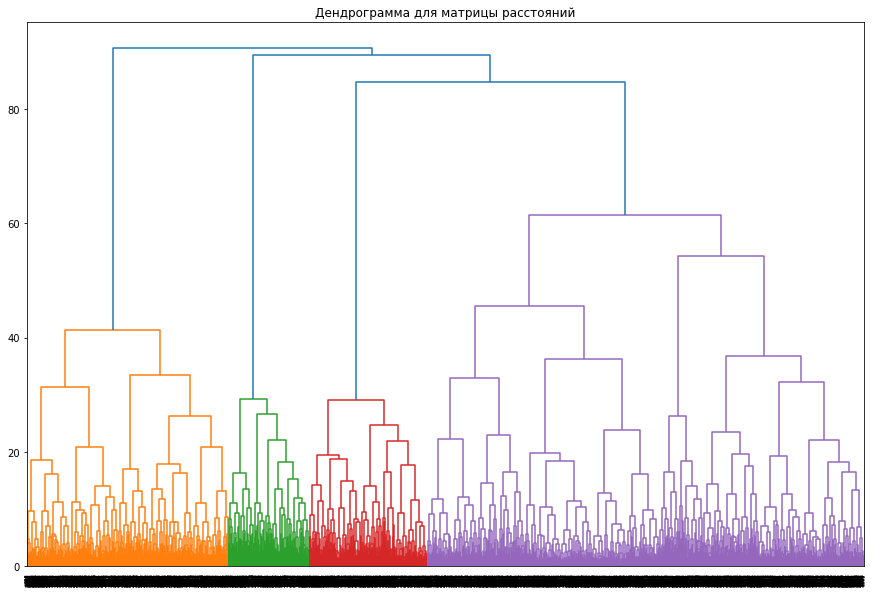

In [38]:
plt.figure(figsize=(15, 10))
dendrogram(linked, orientation='top') 
plt.title('Дендрограмма для матрицы расстояний') 
plt.show()

Предложенно оптимальное число кластеров 5 — пять разных цвета на графике. (Или по количеству цветов на дендрограмме)

### Модель кластеризации на основании алгоритма K-Means

Обучим модель кластеризации на основании алгоритма K-Means и спрогнозируем кластеры клиентов (в таблице отфильтровано по средним значениям признаков churn).

In [39]:
# стандартизируем данные
sc = StandardScaler()
x_sc = sc.fit_transform(df)

# задаём модель k_means с числом кластеров 3 и фиксируем значение random_state
km = KMeans(n_clusters=5, random_state=0)
# прогнозируем кластеры для наблюдений (алгоритм присваивает им номера от 0 до 4)
labels = km.fit_predict(x_sc)

# сохраняем метки кластера в поле нашего датасета
df['cluster_km'] = labels

# выводим статистику по средним значениям наших признаков по кластеру
clusters = df.groupby(['cluster_km']).mean().sort_values(by='churn')
clusters.style.format("{:.6f}").background_gradient(cmap='Blues')


,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,lifetime,avg_class_frequency_current_month,churn
cluster_km,,,,,,,,,,,,
1,0.515504,0.999225,0.215504,0.055039,1.000000,3.871318,0.459690,30.053488,160.909493,4.747287,2.050258,0.001550
3,0.501446,0.992285,0.936355,0.810029,1.000000,8.632594,0.527483,29.926712,158.815978,4.702025,2.031302,0.005786
2,0.523316,0.862694,0.471503,0.305699,0.000000,4.777202,0.427461,29.297927,144.208179,3.940415,1.723967,0.266839
0,0.500898,0.000000,0.486535,0.073609,1.000000,2.989228,0.236984,28.700180,137.060646,2.987433,1.594266,0.403950
4,0.513699,1.000000,0.335616,0.224658,1.000000,1.739726,0.290411,26.902740,114.386793,0.978082,1.045833,0.993151


---  

Выводы:  

* В кластере 3 собраны - клиенты больше всего склонны к оттоку, среднее значение churn 0.993151, в этом классе самые низкие средние показатели в age, avg_additional_charges_total, lifetime, avg_class_frequency_current_month - они молоды и мало тратят. 


* В кластерах 0 и 1 - самые преданные клиенты, у них максимальные средние значения в near_location, partner, promo_friends, contract_period, group_visits, age,  avg_additional_charges_total - это клиенты в районе 30 лет, живут близко от зала, парнтеры и пришли от друзей, посещают групповые занятия, больше других кластеров тратят.


## Выводы и предложения

Ссуммируем полученные расчеты:

Анализ бинарных признаков:

* соотношение gender (пола) в оттоке примерно одинаково -  около 26%  
* в оттоке near_location=0 почти 40%, это гораздо больше, чем в near_location=1 (24%)  
* в оттоке partner=0 почти 33%, это гораздо больше, чем в partner=1 (19%)
* promo_friends=0 также больше promo_friends=1:  31% против 15  
* значения phone в оттоке примерно одинаково - около 25%  
* group_visits=0 дает в отток 33% против 17% в group_visits=1  

near_location, partner, promo_friends, group_visits =0 влияют на отток,  gender и phone - не вляют на отток

Анализ непрерывных признаков:

* среднее значение contract_period при churn=1 составляет =  1.73, самое популярное время  для оттока для длительности текущего действующего абонемента - 1 месяц   
* среднее значение в age при churn=1 составляет =  26.99 - в этом возрасте отток = 1
* суммарная выручка от других услуг фитнес-центрав оттоке avg_additional_charges_total при churn=1 =  115.08
* среднее значение в month_to_end_contract при churn=1 составляет =  1.66, похоже с contract_period   
* среднее значение в lifetime при churn=1 составляет =  0.99, в оттоке не остаются на второй месяц  
* среднее значение в avg_class_frequency_total при churn=1 составляет =  1.47, средняя частота посещений "оттока" в неделю  - меньше 2х раз   
* среднее значение в avg_class_frequency_current_month при churn=1 составляет =  1.04, мало тратили в последний месяц

Значения корреляций:  

Все зависимости не больше умеренного уровня. И почти все обратной зависимости. Самые коррелирующие признаки:

* lifetime  
* avg_class_frequency_current_month  
* age  
* contract_period  
* month_to_end_contract  

Минимальные значения у gender и phone.


Строить прогрнозы лучше логистической регрессией.

Разделили клиентов на 5 кластеров:

* В кластере 3 собраны - клиенты больше всего склонны к оттоку, среднее значение churn 0.993151, в этом классе самые низкие средние показатели в age, avg_additional_charges_total, lifetime, avg_class_frequency_current_month - они молоды и мало тратят. 


* В кластерах 0 и 1 - самые преданные клиенты, у них максимальные средние значения в near_location, partner, promo_friends, contract_period, group_visits, age,  avg_additional_charges_total - это клиенты в районе 30 лет, живут близко от зала, парнтеры и пришли от друзей, посещают групповые занятия, больше других кластеров тратят.


**Предложения:**  

* предварительный анализ и матрица корреляций показала высокую значимость признака age, и при разделении на кластеры видно, что постоянные клиенты более возрастные, поэтому есть смысл фокусироваться на клиентах молодых, именно они дают отток, средний возраст 27 лет - в этом возрасте клиенты уходят в отток. Удерживая молодых клиентов отток уменьшится.

* contract_period и month_to_end_contract значительно влияют на отток и видно на средних значениях кластеров, то есть, стимулируя увеличения времени абонемента и продления на последнем месяце, отток можно сократить.

* так же стоит отметить, что partner, promo_friends и group_visits влияют на отток. В кластерах узнаются портреты клиентов: в классе 0 более возрастные клиенты без partner, promo_friends, а в кластере 1 максимальные средние значения partner, promo_friends и group_visits, то есть это первооткрыватели и их друзья, посещающие групповые занятия. Увеличение притока и уменьшение оттока, согласно расчетам, могут дать привлечение по промокодам и групповые занятия.
